# **Inventory and Merge Runs of well log LAS data stored as seperate files**
---
---
# Use the files in the **"_rename"** folder:

In [1]:

import warnings
warnings.filterwarnings("ignore")

import os, glob, re

import lasio
from lasio import CurveItem

import pandas as pd
import panel as pn

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches  # Import for manually creating colored legend labels


# Initialize Panel
pn.extension()

import base64
from io import BytesIO
#from IPython.core.display import display, HTML
from IPython.display import display, HTML

pn.extension(sizing_mode="stretch_width")

SUFFIXES = ( "_renamed")

# --- helpers ---
def find_renamed_folders():
    # looks in CURRENT working directory
    folders = []
    for name in sorted(os.listdir(".")):
        if os.path.isdir(name) and name.endswith(SUFFIXES):
            folders.append(name)
    return folders

def list_las_files(folder, pattern="*.las"):
    return sorted(glob.glob(os.path.join(folder, pattern)))

# --- widgets ---
refresh = pn.widgets.Button(name="Refresh", button_type="primary")
folder_select = pn.widgets.Select(name="Select renamed folder", options=[])
pattern = pn.widgets.TextInput(name="File pattern", value="*.las")

# --- output panes ---
cwd_md    = pn.pane.Markdown("")
status_md = pn.pane.Markdown("")
files_md  = pn.pane.Markdown("", sizing_mode="stretch_both")

# --- globals this cell will define for downstream notebook cells ---
file_directory = None   # selected folder name
active_dir = None       # same as selected folder path (./<folder>)
las_files = []          # list of LAS files in active_dir

def sync_state_and_render():
    """Update folder list, set globals (file_directory/active_dir/las_files), render output."""
    global file_directory, active_dir, las_files

    # Always show where we are scanning
    cwd_md.object = f"**Current working directory:** `{os.getcwd()}`"

    # Update dropdown options
    folders = find_renamed_folders()
    folder_select.options = folders

    # Preserve selection if possible
    if folders:
        if folder_select.value not in folders:
            folder_select.value = folders[0]
    else:
        folder_select.value = None

    # If nothing to select, clear state
    if not folder_select.value:
        file_directory = None
        active_dir = None
        las_files = []
        status_md.object = "⚠️ No folders ending in `_rename` or `_renamed` found in the current working directory."
        files_md.object = ""
        return

    # Set "working folder" state
    file_directory = folder_select.value
    active_dir = os.path.join(".", file_directory)
    las_files = list_las_files(active_dir, pattern.value.strip() or "*.las")

    # Render
    status_md.object = (
        f"### Working folder set\n"
        f"**file_directory:** `{file_directory}`  \n"
        f"**active_dir:** `{os.path.abspath(active_dir)}`  \n\n"
        f"**LAS files found:** {len(las_files)}"
    )
    files_md.object = "❌ No matching files." if not las_files else "\n".join([f"- `{f}`" for f in las_files])

def on_refresh(event=None):
    sync_state_and_render()

# Reactive updates
refresh.on_click(on_refresh)
folder_select.param.watch(lambda e: sync_state_and_render(), "value")
pattern.param.watch(lambda e: sync_state_and_render(), "value")

# Initial run
sync_state_and_render()

pn.Column(
    "## Select renamed folder (sets `file_directory`, `active_dir`, `las_files`)",
    pn.Row(folder_select, pattern, refresh),
    pn.pane.Markdown("---"),
    cwd_md,
    status_md,
    files_md,
)


Column(sizing_mode='stretch_width')
    [0] Markdown(str, sizing_mode='stretch_width')
    [1] Row(sizing_mode='stretch_width')
        [0] Select(options=['16841-DeadwoodCanyon_ren...], sizing_mode='stretch_width', value='16841-DeadwoodCanyon_rena...)
        [1] TextInput(name='File pattern', sizing_mode='stretch_width', value='*.las')
        [2] Button(button_type='primary', name='Refresh', sizing_mode='stretch_width')
    [2] Markdown(str, sizing_mode='stretch_width')
    [3] Markdown(str, sizing_mode='stretch_width')
    [4] Markdown(str, sizing_mode='stretch_width')
    [5] Markdown(str, sizing_mode='stretch_both')

---
# Plot Presence of all available log curve data colored by las file

## First create an Andy McDonald type of depth plot that highlights the depths that have data for each log curve for each run colored by las file:

Andy has some great tutorials available on GitHub, LinkedIn and Medium. 

Plot saved as Depth_plot_Andy_DEADWOOD_CANYON_RANCH_43-28H_16841-DeadwoodCanyon_renamed_colored_by_las_file.png_colored_by_las_file


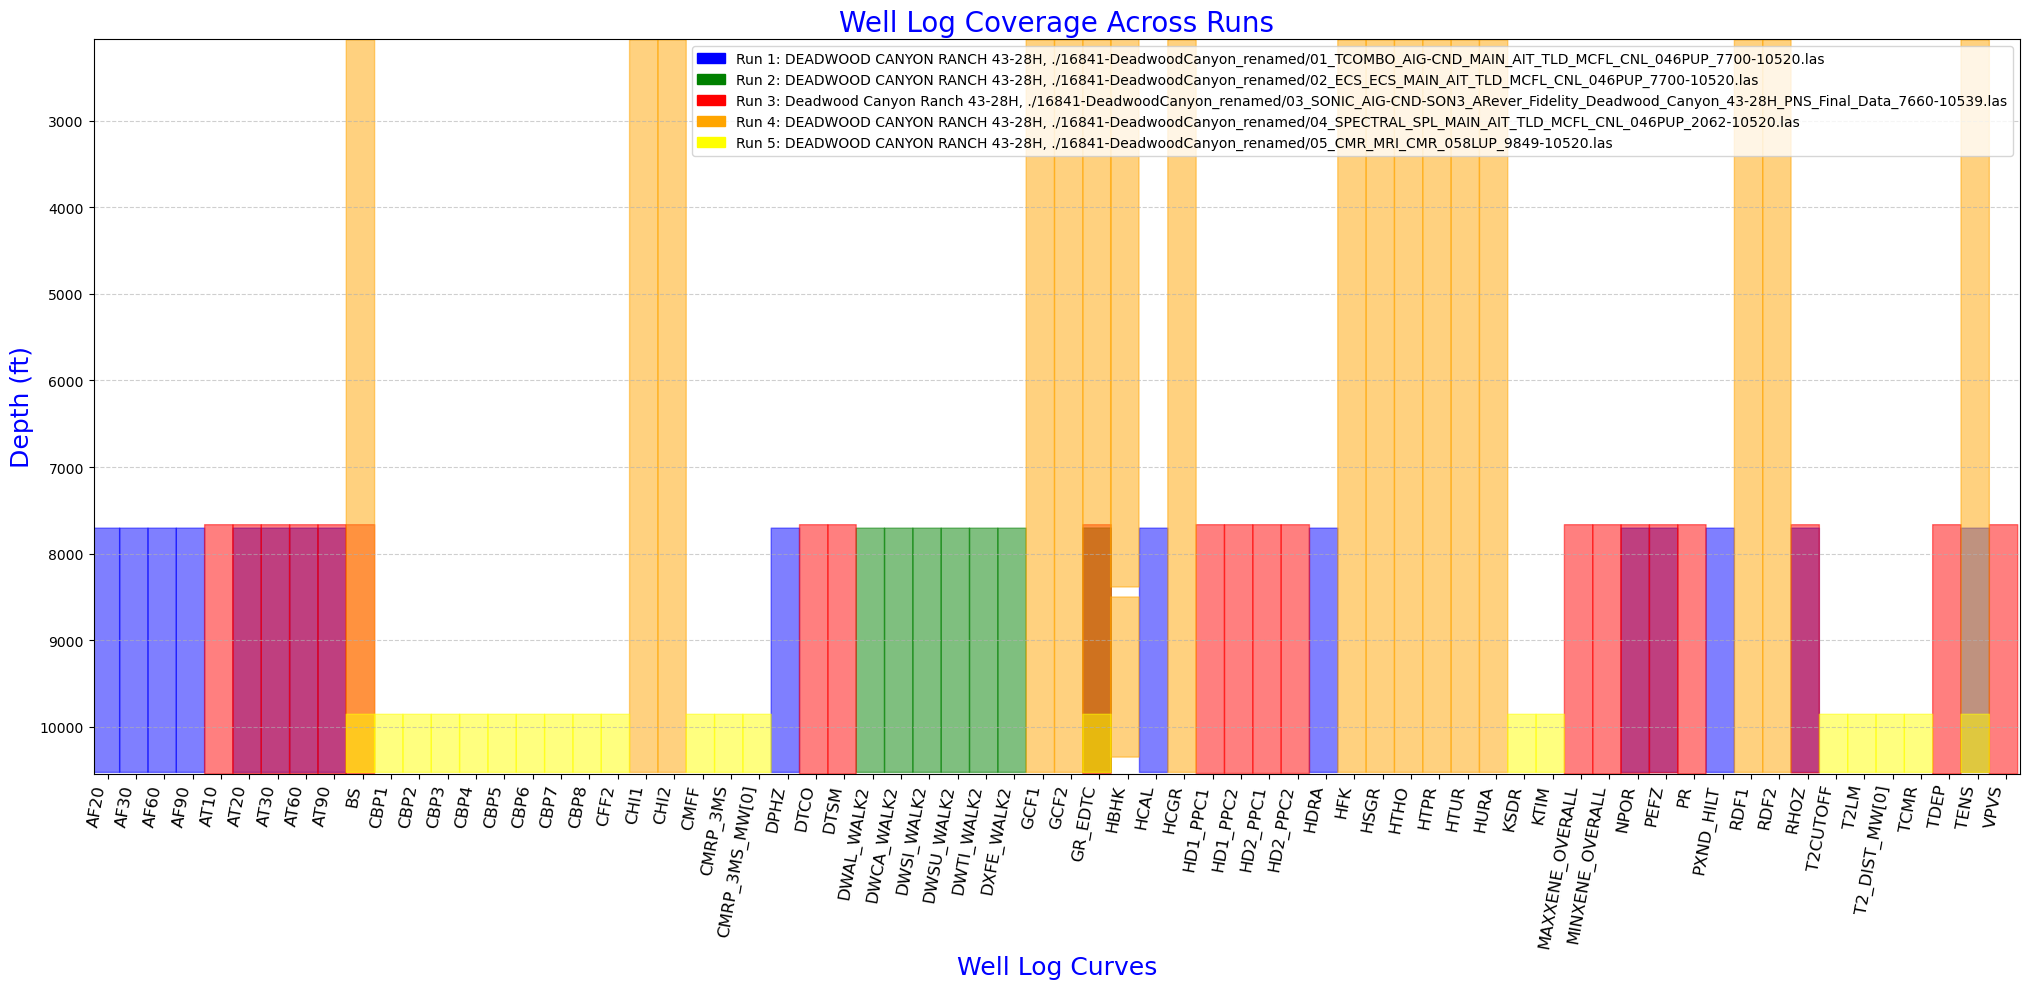

In [2]:
# Function to read LAS file and extract depth and log availability
def get_well_nan(file):
    las = lasio.read(file)
    df_log = las.df()
    df_log.index = las["DEPT"]
    well_nan = df_log.notnull().astype(int)  # Convert to binary (1=Available, 0=Missing)
    wellname = las.well.WELL.value if "WELL" in las.well else file  # Get well name
    return wellname, df_log.index, well_nan

# Read all LAS files and store data
las_data = [get_well_nan(file) for file in las_files]

# Get a unique list of all well log curves across runs
all_available_curves = sorted(set().union(*[df.columns for _, _, df in las_data]))

# Determine global min and max depth across all runs
min_depth = min(min(depth) for _, depth, _ in las_data)
max_depth = max(max(depth) for _, depth, _ in las_data)

# Assign distinct colors for each run
run_colors = ["blue", "green", "red", "orange", "yellow", "black","purple","cyan","gray","violet","limegreen","teal"]
alpha = 0.5  # Transparency for shading

# Create figure with tracks for all unique curves
fig, ax = plt.subplots(figsize=(len(all_available_curves) * 0.3, 10))  # Increase width for better label spacing

# Well name storage for legend (with correct colors)
legend_patches = []

# Loop through each LAS file and shade where logs are present
for run_index, (wellname, depth, well_nan) in enumerate(las_data):
    legend_patches.append(mpatches.Patch(color=run_colors[run_index], label=f"Run {run_index+1}: {wellname}, {las_files[run_index]}"))    
    #legend_patches.append(mpatches.Patch(color=run_colors[run_index], label=f"Run {run_index+1}: {wellname}"))
    for j, curve in enumerate(all_available_curves):
        if curve in well_nan.columns:
            ax.fill_betweenx(depth, j - 0.6, j + 0.4, where=well_nan[curve] == 1, 
                             color=run_colors[run_index], alpha=alpha)

# Format plot
ax.set_xlim(-0.5, len(all_available_curves) - 0.5)  # Keep x-axis aligned
ax.set_ylim(max_depth, min_depth)  # Ensure depth increases downward
ax.set_xticks(range(len(all_available_curves)))
ax.set_xticklabels(all_available_curves, rotation=80, fontsize=12, ha="right")  # Rotate & align right
ax.set_xlabel("Well Log Curves", fontsize=18, color = 'blue')
ax.set_ylabel("Depth (ft)", fontsize=18, color = 'blue')
ax.set_title("Well Log Coverage Across Runs", fontsize=20, color='blue')
ax.grid(axis="y", linestyle="--", alpha=0.6)

# Add well names to legend (ensuring correct colors)
ax.legend(handles=legend_patches, loc="upper right", fontsize=10, frameon=True)

plt.subplots_adjust(bottom=0.25)  # Extra space for x-axis labels
plt.tight_layout()

# **Create output filenames using the well name**
wellname = wellname.replace("#", "").replace(" ", "_")  # Sanitize well name


# **Save the image**
'''image_filename = f"Depth_plot_Andy_{wellname}_{file_directory}_colored_by_las_file.png"'''
image_filename = f"Depth_plot_Andy_{wellname}_{file_directory}_colored_by_las_file.png"
fig.savefig(image_filename, format="png", dpi=300, bbox_inches="tight")
print(f"Plot saved as {image_filename}_colored_by_las_file")

plt.show()



---
---
# **Total Curve Inventory for each LAS File**

## Typical report for all meta data for each las files:

Very simple display of well log header data in las file. 

In [19]:
import os
import numpy as np
import pandas as pd
import lasio
import panel as pn

pn.extension("tabulator", sizing_mode="stretch_width")

# ---- Requires las_files from your folder-picker cell ----
if "las_files" not in globals() or not las_files:
    raise ValueError("`las_files` is empty. Run your folder-selection cell first.")

# ---- Simple cache so switching files is fast ----
_LAS_CACHE = {}
def read_las_cached(path):
    if path not in _LAS_CACHE:
        _LAS_CACHE[path] = lasio.read(path)
    return _LAS_CACHE[path]

# ---- UI widgets ----
file_names = [os.path.basename(p) for p in las_files]
file_map = dict(zip(file_names, las_files))

file_selector = pn.widgets.Select(name="LAS file", options=file_names, width=800)

prev_btn = pn.widgets.Button(name="◀ Prev", button_type="default")
next_btn = pn.widgets.Button(name="Next ▶", button_type="default")

sample_curve_choices = pn.widgets.MultiChoice(
    name="Sample curves (shown in table)",
    options=["DEPT","GR","RHOZ","RHOB","TNPH","NPOR","RT","RS","TCMR","CMRP_3MS","BFV","DCAL","CALI","BS","DRHO"],
    value=["DEPT","GR","RHOZ","TNPH"]
)

nrows = pn.widgets.IntInput(name="Sample rows", value=5, start=1, end=50)

# ---- Output panes ----
header_md = pn.pane.Markdown("")
curves_tbl = pn.widgets.Tabulator(pd.DataFrame(), height=260, pagination="local", page_size=12)
well_tbl   = pn.widgets.Tabulator(pd.DataFrame(), height=260, pagination="local", page_size=12)
depth_tbl  = pn.widgets.Tabulator(pd.DataFrame(), height=140)
sample_tbl = pn.widgets.Tabulator(pd.DataFrame(), height=220)

def build_review(file_key, curve_list, nrows_):
    if not file_key:
        return

    path = file_map[file_key]
    las = read_las_cached(path)

    # --- Header / version ---
    las_version = ""
    try:
        if las.version:
            # las.version is a Section; keep it short
            las_version = ", ".join([f"{k}:{v.value}" for k, v in las.version.items() if hasattr(v, "value")])
    except Exception:
        las_version = ""

    header_md.object = (
        f"## Reviewing `{file_key}`\n"
        f"**Path:** `{path}`  \n"
        f"**LAS Version:** `{las_version or 'N/A'}`"
    )

    # --- Well section ---
    well_info = {}
    if getattr(las, "well", None):
        for k, v in las.well.items():
            try:
                unit = (v.unit or "").strip()
                val = v.value
                well_info[str(k)] = f"{val} {unit}".strip() if unit else val
            except Exception:
                well_info[str(k)] = str(v)

    well_df = pd.DataFrame(
        [{"Mnemonic": k, "Value": v} for k, v in well_info.items()]
    )

    # --- Curves section ---
    curve_df = pd.DataFrame(
        [{"Mnemonic": c.mnemonic, "Unit": c.unit, "Description": c.descr} for c in las.curves]
    )

    # --- Depth range ---
    if "DEPT" in las.keys():
        d = np.asarray(las["DEPT"], float)
        d = d[np.isfinite(d)]
        if d.size:
            depth_df = pd.DataFrame([{"Top (min)": float(np.min(d)), "Base (max)": float(np.max(d))}])
        else:
            depth_df = pd.DataFrame([{"Error": "DEPT exists but contains no finite values"}])
    else:
        depth_df = pd.DataFrame([{"Error": "Depth curve ('DEPT') not found"}])

    # --- Sample data table ---
    chosen = [c for c in curve_list if c in las.keys()]
    if "DEPT" in las.keys() and "DEPT" not in chosen:
        chosen = ["DEPT"] + chosen

    if chosen:
        # Build from LAS curves directly
        sample = {}
        for c in chosen:
            try:
                sample[c] = np.asarray(las[c])[: int(nrows_)]
            except Exception:
                sample[c] = [np.nan] * int(nrows_)
        sample_df = pd.DataFrame(sample)
    else:
        sample_df = pd.DataFrame({"Info": ["No selected curves found in this file."]})

    # Push into tables
    curves_tbl.value = curve_df
    well_tbl.value   = well_df
    depth_tbl.value  = depth_df
    sample_tbl.value = sample_df

# Reactive updates (no .map)
def update_all(*_):
    build_review(file_selector.value, sample_curve_choices.value, nrows.value)

file_selector.param.watch(lambda e: update_all(), "value")
sample_curve_choices.param.watch(lambda e: update_all(), "value")
nrows.param.watch(lambda e: update_all(), "value")

# Prev/Next navigation (robust)
def _go(delta):
    opts = list(file_selector.options)  # current options (source of truth)
    cur = file_selector.value

    if not opts:
        return

    # If cur is None or not found, jump to start
    if cur not in opts:
        file_selector.value = opts[0]
        return

    idx = opts.index(cur)
    idx2 = max(0, min(len(opts) - 1, idx + int(delta)))
    file_selector.value = opts[idx2]

prev_btn.on_click(lambda e: _go(-1))
next_btn.on_click(lambda e: _go(+1))

# Initial render
file_selector.value = file_names[0]
update_all()

pn.Column(
    "# Well Log Review (Panel replacement for the print loop)",
    pn.Row(prev_btn, next_btn, file_selector),
    pn.Row(sample_curve_choices, nrows),
    pn.pane.Markdown("---"),
    header_md,
    pn.pane.Markdown("### Curve Inventory"),
    curves_tbl,
    pn.pane.Markdown("### Well Header"),
    well_tbl,
    pn.pane.Markdown("### Depth Range"),
    depth_tbl,
    pn.pane.Markdown("### Sample Data"),
    sample_tbl,
)


Column(sizing_mode='stretch_width')
    [0] Markdown(str, sizing_mode='stretch_width')
    [1] Row(sizing_mode='stretch_width')
        [0] Button(name='◀ Prev', sizing_mode='stretch_width')
        [1] Button(name='Next ▶', sizing_mode='stretch_width')
        [2] Select(name='LAS file', options=['01_TCOMBO_AIG-CND_MAIN_A...], value='01_TCOMBO_AIG-CND_MAIN_AI..., width=800)
    [2] Row(sizing_mode='stretch_width')
        [0] MultiChoice(name='Sample curves (..., options=['DEPT', 'GR', ...], sizing_mode='stretch_width', value=['DEPT', 'GR', ...])
        [1] IntInput(end=50, name='Sample rows', sizing_mode='stretch_width', start=1, value=5)
    [3] Markdown(str, sizing_mode='stretch_width')
    [4] Markdown(str, sizing_mode='stretch_width')
    [5] Markdown(str, sizing_mode='stretch_width')
    [6] Tabulator(height=260, page_size=12, pagination='local', sizing_mode='stretch_width', value=     Mnemonic  ...)
    [7] Markdown(str, sizing_mode='stretch_width')
    [8] Tabulator(height=260, page_size=12, pagination='local', sizing_mode='stretch_width', value=   Mnemonic   ...)
    [9] Markdown(str, sizing_mode='stretch_width')
    [10] Tabulator(height=140, sizing_mode='stretch_width', value=   Top (min)  ...)
    [11] Markdown(str, sizing_mode='stretch_width')
    [12] Tabulator(height=220, sizing_mode='stretch_width', value=     DEPT    R...)

---
---
# **Plot each log curve with an x-range from the 5 percentile to the 95 percentile:**

This is a start, but not perfect. Need to define log10 families of log curves.

## **NEW:** Resistivity (OHMM), Permeability (MD) and Msec (MS) Unit Data Plotted on log scale:
---


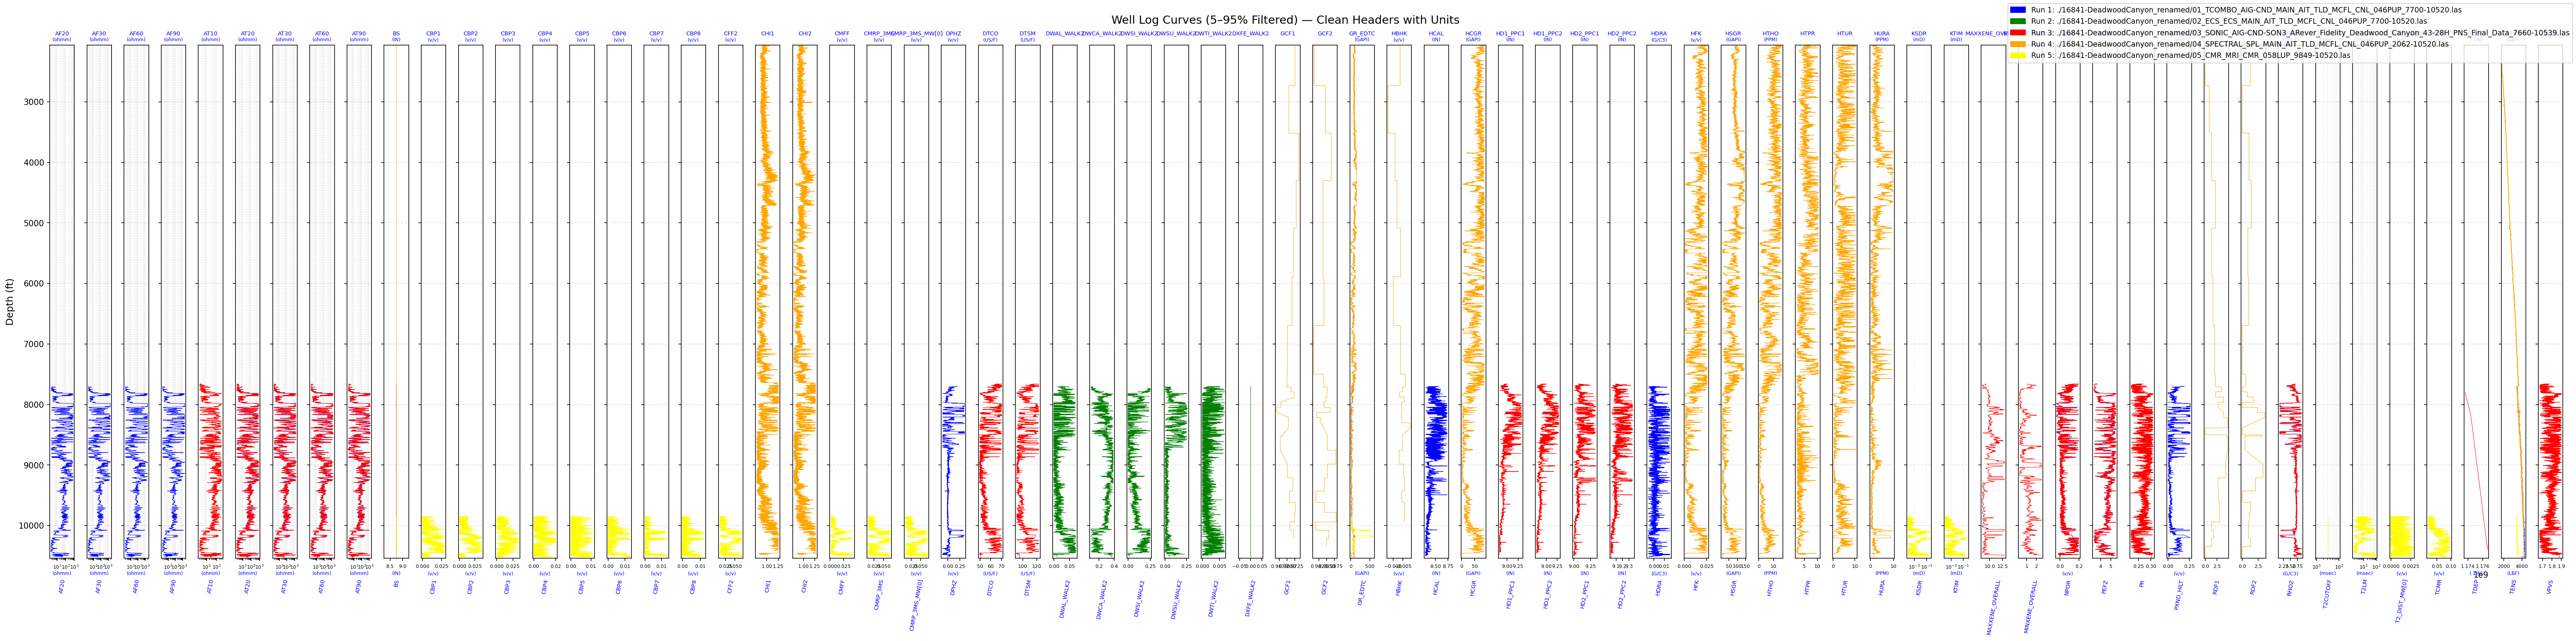

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import lasio
import matplotlib.patches as mpatches
from io import BytesIO
import base64
from IPython.display import display, HTML

# -------------------------------------------------
# Helpers
# -------------------------------------------------
def canonical_unit(u: str) -> str:
    if not u:
        return ""
    su = u.strip().upper().replace(" ", "")

    if su in ["OHMM", "OHM.M", "OHM-M", "OHM/M", "OHM*M", "OHM·M"]:
        return "ohmm"
    if su in ["MD", "MD."]:
        return "mD"
    if su in ["US/FT"]:
        return "µs/ft"
    if su in ["G/CM3", "G/CC"]:
        return "g/cc"
    if su in ["MS", "MSEC"]:
        return "msec"
    if su in ["CFCF", "V/V", "VV"]:
        return "v/v"
        
    return u.strip()


def get_curve_unit(curve, las_data):
    units = []
    for _, _, df, units_map in las_data:
        if curve in df.columns:
            u = canonical_unit(units_map.get(curve, ""))
            if u:
                units.append(u)

    units = sorted(set(units))
    if len(units) == 1:
        return units[0]
    if len(units) > 1:
        return "mixed"
    return ""


def is_log_curve(curve, las_data):
    for _, _, df, units_map in las_data:
        if curve in df.columns:
            if canonical_unit(units_map.get(curve, "")) in ["ohmm", "mD", "msec"]:
                return True
    return False


def safe_log_mask(x):
    return np.isfinite(x) & (x > 0)


# -------------------------------------------------
# Read LAS files
# -------------------------------------------------
def get_filtered_well_data(file):
    las = lasio.read(file)
    df = las.df()
    df.index = las["DEPT"]

    units_map = {c.mnemonic: (c.unit or "") for c in las.curves}

    lo = df.quantile(0.05)
    hi = df.quantile(0.95)

    df_filt = df.apply(
        lambda c: c.where((c >= lo[c.name]) & (c <= hi[c.name]), np.nan),
        axis=0
    )

    wellname = las.well.WELL.value if "WELL" in las.well else file
    return wellname, df.index, df_filt, units_map


las_data = [get_filtered_well_data(f) for f in las_files]

all_curves = sorted(set().union(*[df.columns for _, _, df, _ in las_data]))

min_depth = min(np.nanmin(d) for _, d, _, _ in las_data)
max_depth = max(np.nanmax(d) for _, d, _, _ in las_data)

# -------------------------------------------------
# Plot setup
# -------------------------------------------------
colors = ["blue", "green", "red", "orange", "yellow", "black", "purple", "cyan", "gray", "violet", "limegreen", "teal"]
colors = (colors * 10)[:len(las_files)]

fig, axes = plt.subplots(
    ncols=len(all_curves),
    figsize=(0.65 * len(all_curves), 11),
    sharey=True
)

if len(all_curves) == 1:
    axes = [axes]

legend_handles = [
    mpatches.Patch(color=colors[i], label=f"Run {i+1}: {las_files[i]}")
    for i in range(len(las_files))
]

# -------------------------------------------------
# Plot loop
# -------------------------------------------------
for i, curve in enumerate(all_curves):
    ax = axes[i]

    unit = get_curve_unit(curve, las_data)
    log_scale = is_log_curve(curve, las_data)

    # ---- Top header
    ax.set_title(curve, fontsize=7, color="blue", pad=12)

    # Units below title
    if unit:
        ax.text(
            0.5, 1.015,
            f"({unit})",
            transform=ax.transAxes,
            ha="center",
            va="top",
            fontsize=6,
            color="blue"
        )

    # ---- Plot runs
    for run_i, (_, depth, df, _) in enumerate(las_data):
        if curve not in df.columns:
            continue

        x = df[curve].to_numpy(float)
        y = np.asarray(depth, float)

        if log_scale:
            m = safe_log_mask(x) & np.isfinite(y)
        else:
            m = np.isfinite(x) & np.isfinite(y)

        if np.any(m):
            ax.plot(x[m], y[m], lw=0.5, color=colors[run_i])

    # ---- Axes formatting
    ax.set_ylim(max_depth, min_depth)
    ax.tick_params(axis="x", labelsize=6)
    ax.grid(axis="y", linestyle="--", alpha=0.4)

    if log_scale:
        ax.set_xscale("log")
        ax.grid(True, which="both", axis="x", linestyle=":", alpha=0.3)

    # ---- Bottom curve label (tilted)
    ax.set_xlabel("")
    ax.text(
        0.5, -0.04,
        curve,
        transform=ax.transAxes,
        fontsize=7,
        rotation=80,
        ha="center",   # key: center at x=0.5
        color="blue",
        va="top",
    )
    # Units below curve label
    if unit:
        ax.text(
            0.5, -0.025,
            f"({unit})",
            transform=ax.transAxes,
            ha="center",
            va="top",
            fontsize=6,
            color="blue"
        )

# -------------------------------------------------
# Global formatting
# -------------------------------------------------
axes[0].set_ylabel("Depth (ft)", fontsize=12)
fig.suptitle(
    "Well Log Curves (5–95% Filtered) — Clean Headers with Units",
    fontsize=14
)
fig.legend(handles=legend_handles, loc="upper right", fontsize=9)

plt.tight_layout(w_pad=0.2)

# -------------------------------------------------
# Save + embed
# -------------------------------------------------
buf = BytesIO()
fig.savefig(buf, dpi=150, bbox_inches="tight")
buf.seek(0)

img_b64 = base64.b64encode(buf.read()).decode()
plt.close(fig)

display(HTML(f"""
<div style="overflow-x:auto; border:1px solid #aaa; padding:10px;">
<img src="data:image/png;base64,{img_b64}" style="max-width:none;">
</div>
"""))


## View key logs marked by our Showing Run Numbers:

2062.0
10539.0


Run                                               File  Run Top (ft)  \
0    1  ./16841-DeadwoodCanyon_renamed/01_TCOMBO_AIG-C...        7700.0   
1    2  ./16841-DeadwoodCanyon_renamed/02_ECS_ECS_MAIN...        7700.0   
2    3  ./16841-DeadwoodCanyon_renamed/03_SONIC_AIG-CN...        7660.0   
3    4  ./16841-DeadwoodCanyon_renamed/04_SPECTRAL_SPL...        2062.0   
4    5  ./16841-DeadwoodCanyon_renamed/05_CMR_MRI_CMR_...        9849.0   

   Run Base (ft)  Plot Window Top (ft)  Plot Window Base (ft)  \
0        10520.0                2062.0                10539.0   
1        10520.0                2062.0                10539.0   
2        10539.0                2062.0                10539.0   
3        10520.0                2062.0                10539.0   
4        10520.0                2062.0                10539.0   

                                    Available Curves  
0  AF20, AF30, AF60, AF90, AT20, AT30, AT60, AT90...  
1  DEPT, DWAL_WALK2, DWCA_WALK2, DWSI_WALK2, DWSU...  
2  AT10, AT20, AT30, AT60, AT90, BS, DEPT, DTCO, ...  
3  BS, CHI1, CHI2, DEPT, GCF1, GCF2, GR_EDTC, HBH...  
4  BS, CBP1, CBP2, CBP3, CBP4, CBP5, CBP6, CBP7, ...

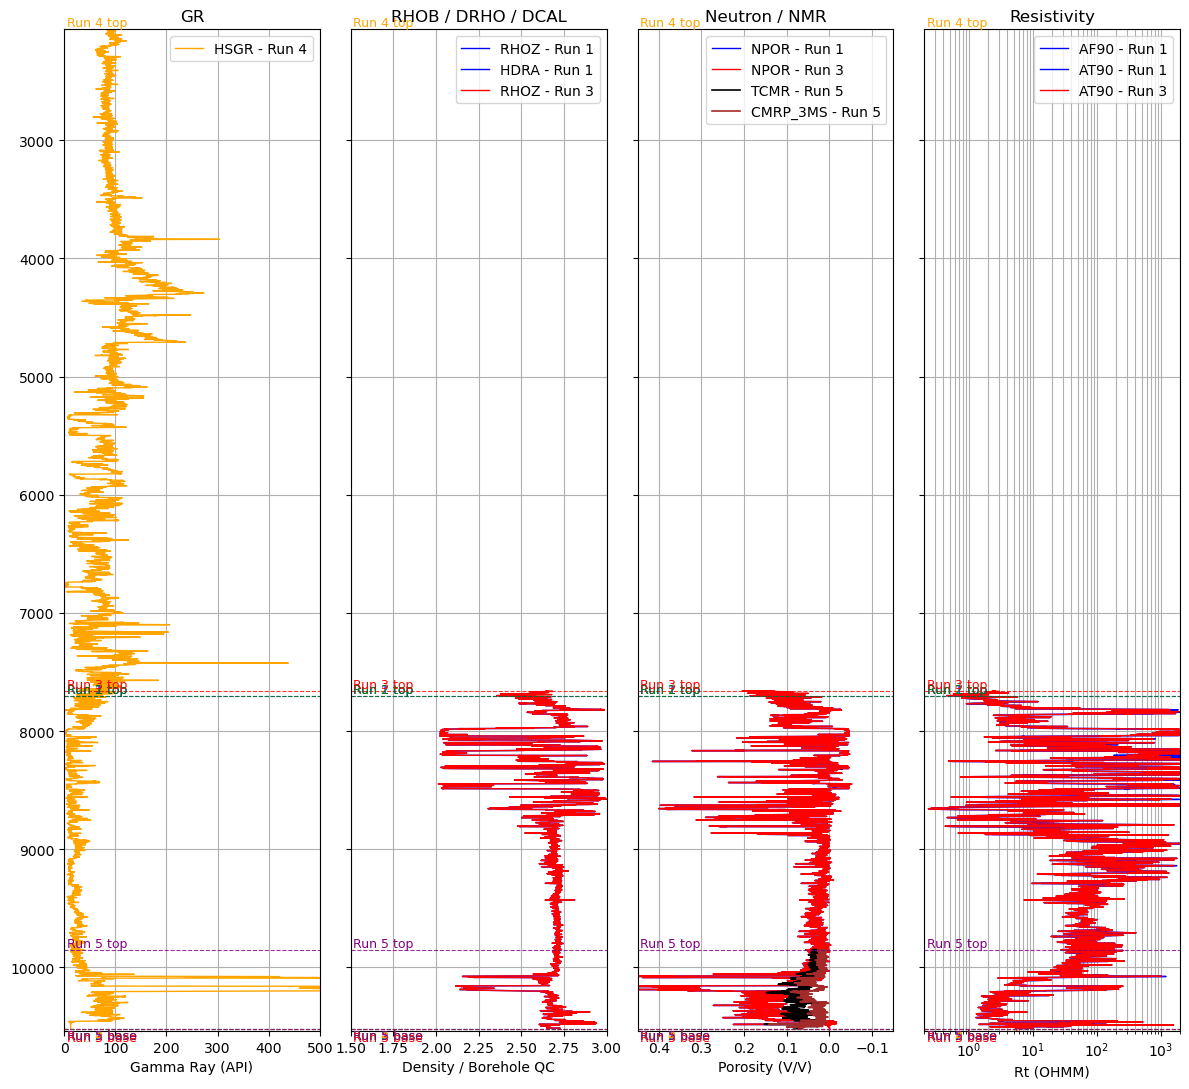

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lasio

# Global depth range across runs
min_depth = min(np.nanmin(depth) for _, depth, _, _ in las_data)
max_depth = max(np.nanmax(depth) for _, depth, _, _ in las_data)

print(min_depth)
print(max_depth)

# -----------------------------
# 1) Define curve families
# -----------------------------
curve_families = {
    "GR":      ["GR", "HSGR", "SGR"],
    "RHOB":    ["RHOB", "RHOZ"],
    "DRHO":    ["DRHO", "HDRA", "HDRH", "DROH", "DRH", "RHOC"],
    "BS":      ["BS", "BITSIZE", "BIT", "BIT_SIZE"],
    "CALI":    ["HD1_PPC1", "HD2_PPC1", "CALI", "HCAL", "C1", "C2", "CAL", "CALIPER"],
    "DCAL":    ["DCAL", "DCALI", "D_CAL", "CALD"],
    "TNPH":    ["TNPH", "NPHI", "NPOR", "CNL"],
    "POR_NMR": ["TCMR", "CMRP_3MS", "BFV"],
    "RT":      ["RT", "AF90", "AT90", "AO90"],
    "PERM":    ["PERM", "K", "KH", "KVERT", "KMD", "PERM_MD", "PERM_M", "KLOGH", "KLOG"],
}

curve_style = {
    "RHOB": {"color": "black", "linewidth": 1.2},
    "DRHO": {"color": "red",   "linewidth": 1.0},
    "DCAL": {"color": "purple","linewidth": 1.0},

    "TCMR":     {"color": "black", "linewidth": 1.2},
    "CMRP_3MS": {"color": "brown", "linewidth": 1.2},
    "BFV":      {"color": "blue",  "linewidth": 1.2},
}

fill_between = {
    "track": "POR_NMR",
    "left": "TCMR",
    "right": "BFV",
    "color": "yellow",
    "alpha": 0.35
}

family_plot_config = {
    "RT":   {"xscale": "log"},
    "PERM": {"xscale": "log"},
}

# -----------------------------
# 2) Read LAS files
# -----------------------------
logs = []
for file in las_files:
    las = lasio.read(file)

    depth = np.asarray(las["DEPT"], float)
    depth = depth[np.isfinite(depth)]



    
    top_depth = min_depth
    bottom_depth = max_depth



    
    curve_info = {
        curve.mnemonic: (las[curve.mnemonic].min(), las[curve.mnemonic].max())
        for curve in las.curves
    }

    data = {
        "file": file,
        "depth": las["DEPT"],
        "run_top": float(np.nanmin(depth)) if depth.size else np.nan,
        "run_base": float(np.nanmax(depth)) if depth.size else np.nan,
        #"depth_min": top_depth,
        #"depth_max": bottom_depth,
        "depth_min": min_depth,
        "depth_max": max_depth,
        "curves": curve_info
    }

    needed = set(mn for fam in curve_families.values() for mn in fam)
    for mn in needed:
        data[mn] = las[mn] if mn in las.curves else None

    logs.append(data)

# -----------------------------
# 3) Inventory table with run start/stop
# -----------------------------
df_inventory = pd.DataFrame([
    {
        "Run": i + 1,
        "File": log["file"],
        "Run Top (ft)": log["run_top"],
        "Run Base (ft)": log["run_base"],
        #"Plot Window Top (ft)": log["depth_min"],
        #"Plot Window Base (ft)": log["depth_max"],
        "Plot Window Top (ft)": min_depth,
        "Plot Window Base (ft)": max_depth,
        "Available Curves": ", ".join(sorted(log["curves"].keys()))
    }
    for i, log in enumerate(logs)
])

display(df_inventory)

# -----------------------------
# 4) Helpers
# -----------------------------
def plot_track(ax, track_keys, xlim=None, xscale=None, xlabel="", title=""):
    #colors = ["blue", "green", "red", "orange", "purple", "cyan", "gray", "teal"]
    colors = ["blue", "green", "red", "orange", "yellow", "black","purple","cyan","gray","violet","limegreen","teal"]


    if isinstance(track_keys, str):
        track_keys = [track_keys]

    if xscale is None:
        for k in track_keys:
            cfg = family_plot_config.get(k, {})
            if "xscale" in cfg:
                xscale = cfg["xscale"]
                break

    mnemonics = []
    for key in track_keys:
        mnemonics.extend(curve_families.get(key, []))

    for i, log in enumerate(logs):
        depth = np.asarray(log["depth"], float)

        for mn in mnemonics:
            if log.get(mn) is None:
                continue

            x = np.asarray(log[mn], float)

            if xscale == "log":
                m = (
                    np.isfinite(depth) &
                    np.isfinite(x) &
                    (x > 0) &
                    (depth >= top_depth) &
                    (depth <= bottom_depth)
                )
            else:
                m = (
                    np.isfinite(depth) &
                    np.isfinite(x) &
                    (depth >= top_depth) &
                    (depth <= bottom_depth)
                )

            if not np.any(m):
                continue

            style = {"color": colors[i % len(colors)], "linewidth": 1.0}
            if mn in curve_style:
                style.update(curve_style[mn])

            ax.plot(x[m], depth[m], label=f"{mn} - Run {i+1}", **style)

    ax.set_ylim(top_depth, bottom_depth)
    ax.invert_yaxis()
    if xlim is not None:
        ax.set_xlim(*xlim)
    if xscale is not None:
        ax.set_xscale(xscale)
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    ax.grid(True, which="both")
    ax.legend()

def add_fill_between(ax):
    left = fill_between["left"]
    right = fill_between["right"]

    for log in logs:
        if log.get(left) is None or log.get(right) is None:
            continue

        depth = np.asarray(log["depth"], float)
        x1 = np.asarray(log[left], float)
        x2 = np.asarray(log[right], float)

        m = (
            (depth >= top_depth) &
            (depth <= bottom_depth) &
            np.isfinite(x1) &
            np.isfinite(x2)
        )

        if np.any(m):
            ax.fill_betweenx(
                depth[m],
                x1[m],
                x2[m],
                color=fill_between["color"],
                alpha=fill_between["alpha"]
            )

def add_run_markers(ax):
    """
    Draw run top/base lines for each LAS run and label them.
    Uses the same color cycle as plotting so it visually matches.
    """
    colors = ["blue", "green", "red", "orange", "purple", "cyan", "gray", "teal"]

    # Put labels near the left edge of the track in axes coordinates
    x_text = 0.01

    for i, log in enumerate(logs):
        c = colors[i % len(colors)]
        rt = log.get("run_top", np.nan)
        rb = log.get("run_base", np.nan)

        # Only draw if within plotting window
        if np.isfinite(rt) and (top_depth <= rt <= bottom_depth):
            ax.axhline(rt, color=c, linewidth=0.8, linestyle="--", alpha=0.8)
            ax.text(x_text, rt, f"Run {i+1} top", transform=ax.get_yaxis_transform(),
                    va="bottom", ha="left", fontsize=9, color=c)

        if np.isfinite(rb) and (top_depth <= rb <= bottom_depth):
            ax.axhline(rb, color=c, linewidth=0.8, linestyle="--", alpha=0.8)
            ax.text(x_text, rb, f"Run {i+1} base", transform=ax.get_yaxis_transform(),
                    va="top", ha="left", fontsize=9, color=c)

# -----------------------------
# 5) Plot function
# -----------------------------
def plot_well_logs():
    fig, axes = plt.subplots(1, 4, figsize=(12, 11), sharey=True)

    # Track 1: GR
    plot_track(
        axes[0],
        "GR",
        xlim=(0, 500),
        xlabel="Gamma Ray (API)",
        title="GR"
    )
    add_run_markers(axes[0])

    # Track 2: Density + DRHO + DCAL
    plot_track(
        axes[1],
        ["RHOB", "DRHO", "DCAL"],
        xlim=(1.5, 3.0),
        xlabel="Density / Borehole QC",
        title="RHOB / DRHO / DCAL"
    )
    add_run_markers(axes[1])

    # Track 3: Neutron + NMR
    plot_track(
        axes[2],
        ["TNPH", "POR_NMR"],
        xlim=(0.45, -0.15),
        xlabel="Porosity (V/V)",
        title="Neutron / NMR"
    )
    add_fill_between(axes[2])
    add_run_markers(axes[2])

    # Track 4: Resistivity (log10)
    plot_track(
        axes[3],
        "RT",
        xlim=(0.2, 2000),
        xlabel="Rt (OHMM)",
        title="Resistivity"
    )
    add_run_markers(axes[3])

    plt.tight_layout()
    plt.show()

# Execute
plot_well_logs()


---
---
# **Merge all las file Data:**

Fit any combination of runs.

First plot the merged data as black curves to make sure that this is working:

Plot saved as Merged_Depth_plot_DEADWOOD_CANYON_RANCH_43-28H_16841-DeadwoodCanyon_renamed_black&white.png



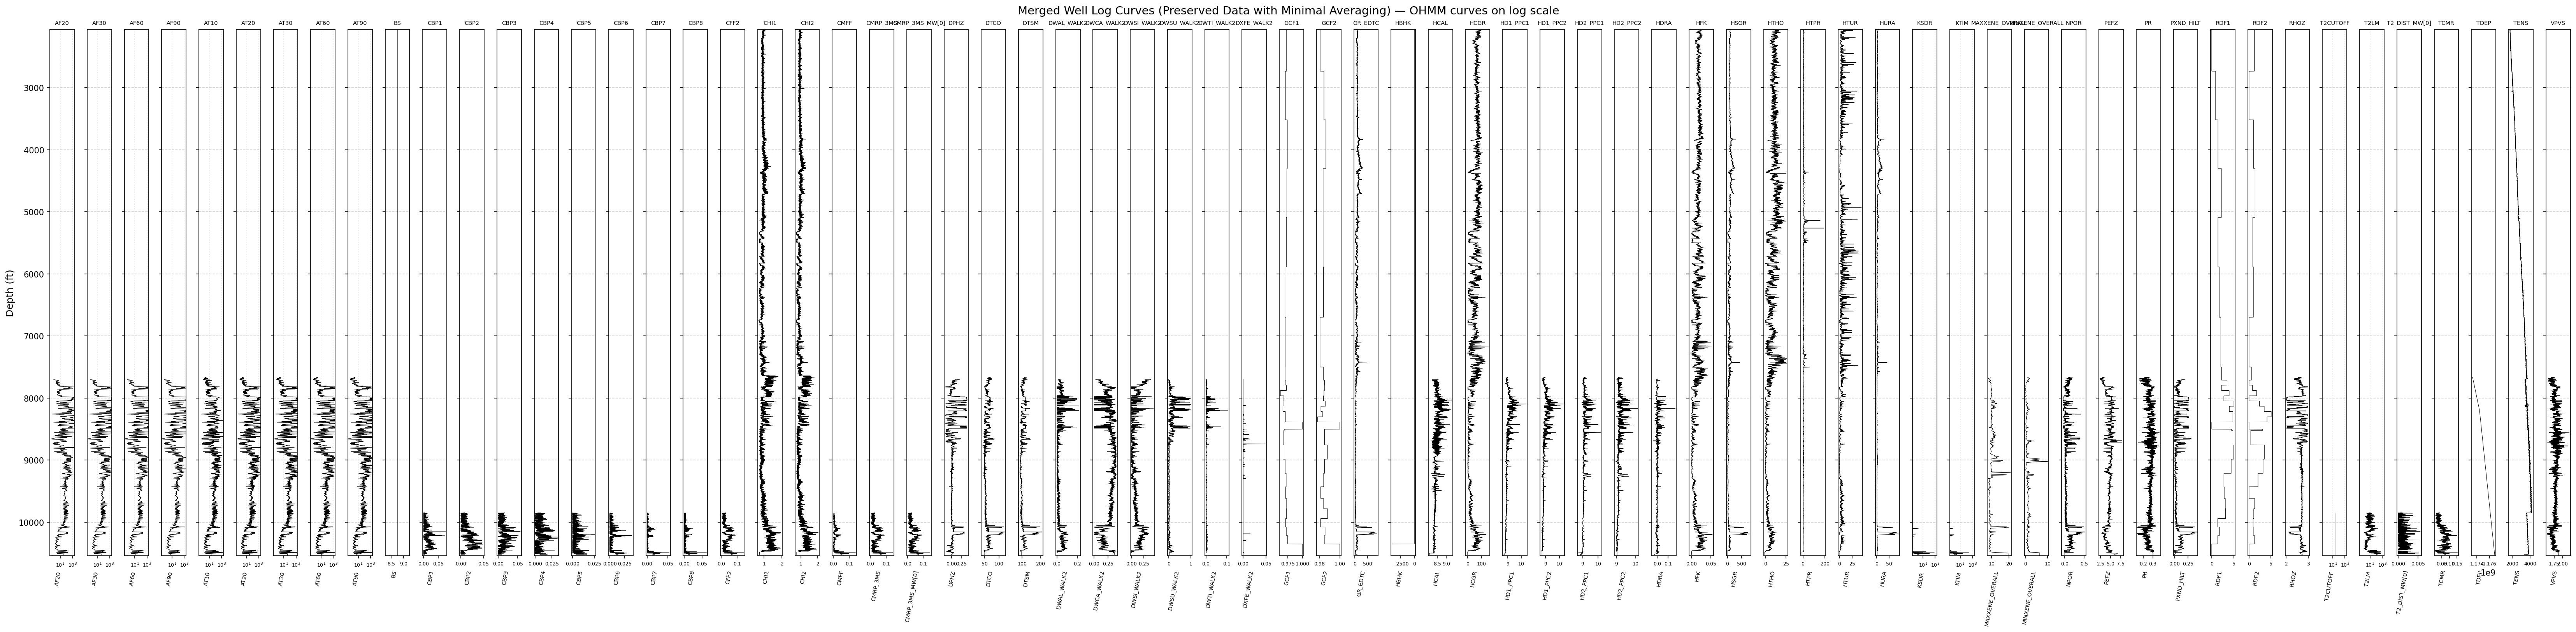

In [7]:
# this might not plot well, but I think the data might be good.

import numpy as np
import pandas as pd
import lasio
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from io import BytesIO
import base64
from IPython.display import display, HTML  

# -----------------------------
# Helper: detect OHMM curves (units) and safely plot on log scale
# -----------------------------
def is_ohmm_curve(curve_name: str, units_map: dict) -> bool:
    u = (units_map.get(curve_name, "") or "").strip().upper().replace(" ", "")
    return any(tok in u for tok in ["OHMM", "OHM.M", "OHM-M", "OHM/M", "MD", "MS"])

# Function to read LAS file and extract depth/log data (+ units map)
def get_filtered_well_data(file):
    las = lasio.read(file)
    df_log = las.df()

    # Ensure depth is unique by averaging duplicate values
    df_log = df_log.groupby("DEPT").mean().reset_index()
    df_log.set_index("DEPT", inplace=True)

    # units map: mnemonic -> unit string
    units_map = {c.mnemonic: (c.unit or "") for c in las.curves}

    wellname = las.well.WELL.value if "WELL" in las.well else file  
    return wellname, df_log.index, df_log, units_map

# Read all LAS files
las_data = [get_filtered_well_data(file) for file in las_files]

# Build a combined units map (first non-empty unit wins)
combined_units_map = {}
for _, _, df, units_map in las_data:
    for c in df.columns:
        if c not in combined_units_map or not combined_units_map[c]:
            combined_units_map[c] = units_map.get(c, "") or combined_units_map.get(c, "")

# **Ensure all depths from all LAS files are included in `merged_depth_index`**
all_depths = np.unique(np.concatenate([depth.values for _, depth, _, _ in las_data]))
merged_depth_index = np.sort(all_depths)

# Get all unique well log curves across runs
all_available_curves = sorted(set().union(*[df.columns for _, _, df, _ in las_data]))

# Create an empty DataFrame for merged data
merged_df = pd.DataFrame(index=merged_depth_index, columns=all_available_curves, dtype=float)

# **Improved Merging Strategy: Preserve Original Data**
for _, depth, df_log, _ in las_data:
    df_log = df_log.loc[~df_log.index.duplicated(keep="first")]  # Ensure unique depth values

    for curve in all_available_curves:
        if curve not in df_log.columns:
            continue

        valid_mask = df_log[curve].notna()
        valid_depths = df_log.index[valid_mask]

        if valid_depths.size == 0:
            continue

        # If the curve does not exist in merged_df, assign it directly
        if merged_df.loc[valid_depths, curve].isna().all():
            merged_df.loc[valid_depths, curve] = df_log.loc[valid_depths, curve].astype(float)
        else:
            # Merge using a weighted approach in overlapping regions
            overlap_mask = merged_df.loc[valid_depths, curve].notna()

            # Fill where merged is empty
            merged_df.loc[valid_depths[~overlap_mask], curve] = df_log.loc[valid_depths[~overlap_mask], curve].astype(float)

            # Blend overlap (favor newer run)
            merged_df.loc[valid_depths[overlap_mask], curve] = (
                df_log.loc[valid_depths[overlap_mask], curve].astype(float) * 0.7 +
                merged_df.loc[valid_depths[overlap_mask], curve].astype(float) * 0.3
            )

# -----------------------------
# Plot the merged well log curves
# -----------------------------
fig, axes = plt.subplots(
    nrows=1,
    ncols=len(all_available_curves),
    figsize=(len(all_available_curves) * 0.65, 11),
    sharey=True
)

# If only one curve, axes is not a list; normalize
if len(all_available_curves) == 1:
    axes = [axes]

for i, curve in enumerate(all_available_curves):
    ax = axes[i]
    ax.set_title(curve, fontsize=7)

    # Determine if curve should be log-scale (OHMM units)
    curve_is_log = is_ohmm_curve(curve, combined_units_map)

    # Extract data
    x = merged_df[curve].to_numpy(dtype=float)
    y = merged_depth_index.astype(float)

    # Plot with proper masking for log scale
    if np.isfinite(x).any():
        if curve_is_log:
            m = np.isfinite(x) & np.isfinite(y) & (x > 0)
            if np.any(m):
                ax.plot(x[m], y[m], linewidth=0.5, color="black")
                ax.set_xscale("log")
                ax.grid(True, which="both", axis="x", linestyle=":", alpha=0.35)
                ax.set_xlim(0.2,2000)
            else:
                # nothing valid for log scale
                pass
        else:
            m = np.isfinite(x) & np.isfinite(y)
            if np.any(m):
                ax.plot(x[m], y[m], linewidth=0.5, color="black")

    # Formatting
    ax.set_ylim(merged_depth_index[-1], merged_depth_index[0])  # Depth increases downward
    ax.set_xlabel(curve, fontsize=7, rotation=80, ha="right")
    ax.tick_params(axis="x", labelsize=6)
    ax.grid(axis="y", linestyle="--", alpha=0.6)

# Formatting
axes[0].set_ylabel("Depth (ft)", fontsize=12)
fig.suptitle("Merged Well Log Curves (Preserved Data with Minimal Averaging) — OHMM curves on log scale", fontsize=14)

# Output filename using first run's wellname (consistent)
wellname0 = (las_data[0][0] if las_data else "WELL").replace("#", "").replace(" ", "_")

plt.tight_layout(pad=1.0, w_pad=0.2)
image_filename = f"Merged_Depth_plot_{wellname0}_{file_directory}_black&white.png"
fig.savefig(image_filename, format="png", dpi=300, bbox_inches="tight")
print(f"Plot saved as {image_filename}")

# Convert figure to PNG and encode in base64
buffer = BytesIO()
fig.savefig(buffer, format="png", bbox_inches="tight", dpi=150)
buffer.seek(0)
encoded_image = base64.b64encode(buffer.read()).decode("utf-8")
buffer.close()
plt.close(fig)

# Embed in Jupyter Notebook
html_code = f"""
<div style="width: 100%; overflow-x: auto; border: 1px solid black; white-space: nowrap; padding: 10px;">
    <img src="data:image/png;base64,{encoded_image}" style="max-width: none;"/>
</div>
"""
display(HTML(html_code))


## **QC Check** - *merged data as thin yellow curves plotted over individual runs color by las file:*

Plot saved as Merged_Depth_plot_DEADWOOD_CANYON_RANCH_43-28H_16841-DeadwoodCanyon_renamed_yellow-line_plotted-over-colored-individual-las-files_QC-check.png



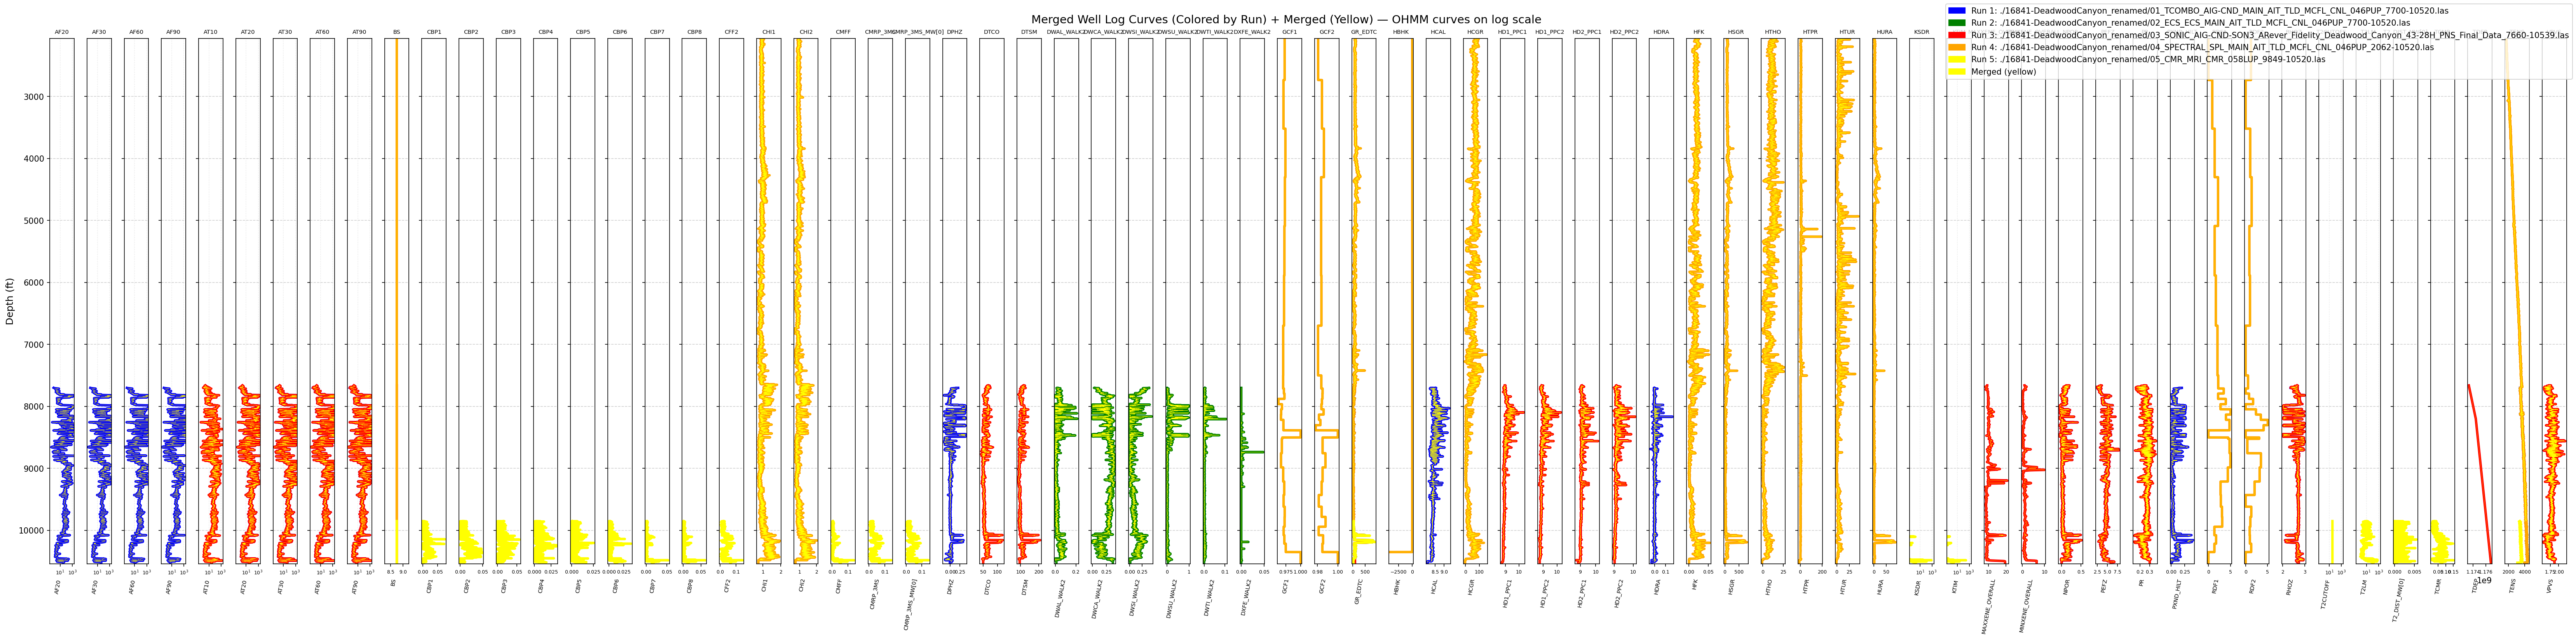

In [8]:
# this might not plot well, but I think the data might be good.

import numpy as np
import pandas as pd
import lasio
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from io import BytesIO
import base64
from IPython.display import display, HTML  

# -----------------------------
# Helper: detect OHMM curves (units) and safely plot on log scale
# -----------------------------
def is_ohmm_curve(curve_name: str, units_map: dict) -> bool:
    u = (units_map.get(curve_name, "") or "").strip().upper().replace(" ", "")
    return any(tok in u for tok in ["OHMM", "OHM.M", "OHM-M", "OHM/M","MD", "MS"])

def safe_log_mask(x: np.ndarray) -> np.ndarray:
    return np.isfinite(x) & (x > 0)

# Function to read LAS file and extract depth/log data (+ units map)
def get_filtered_well_data(file):
    las = lasio.read(file)
    df_log = las.df()

    # Ensure depth is unique by averaging duplicate values
    df_log = df_log.groupby("DEPT").mean().reset_index()
    df_log.set_index("DEPT", inplace=True)

    units_map = {c.mnemonic: (c.unit or "") for c in las.curves}

    wellname = las.well.WELL.value if "WELL" in las.well else file  
    return wellname, df_log.index, df_log, units_map

# -----------------------------
# Read all LAS files
# -----------------------------
las_data = [get_filtered_well_data(file) for file in las_files]

# Build a combined units map (first non-empty unit wins)
combined_units_map = {}
for _, _, df, units_map in las_data:
    for c in df.columns:
        if c not in combined_units_map or not combined_units_map[c]:
            combined_units_map[c] = units_map.get(c, "") or combined_units_map.get(c, "")

# Ensure all depths from all LAS files are included in merged_depth_index
all_depths = np.unique(np.concatenate([depth.values for _, depth, _, _ in las_data]))
merged_depth_index = np.sort(all_depths)

# Get all unique well log curves across runs
all_available_curves = sorted(set().union(*[df.columns for _, _, df, _ in las_data]))

# Create an empty DataFrame for merged data
merged_df = pd.DataFrame(index=merged_depth_index, columns=all_available_curves, dtype=float)

# -----------------------------
# Improved Merging Strategy: Preserve Original Data
# -----------------------------
for _, depth, df_log, _ in las_data:
    df_log = df_log.loc[~df_log.index.duplicated(keep="first")]

    for curve in all_available_curves:
        if curve not in df_log.columns:
            continue

        valid_mask = df_log[curve].notna()
        valid_depths = df_log.index[valid_mask]
        if valid_depths.size == 0:
            continue

        if merged_df.loc[valid_depths, curve].isna().all():
            merged_df.loc[valid_depths, curve] = df_log.loc[valid_depths, curve].astype(float)
        else:
            overlap_mask = merged_df.loc[valid_depths, curve].notna()
            merged_df.loc[valid_depths[~overlap_mask], curve] = df_log.loc[valid_depths[~overlap_mask], curve].astype(float)
            merged_df.loc[valid_depths[overlap_mask], curve] = (
                df_log.loc[valid_depths[overlap_mask], curve].astype(float) * 0.7 +
                merged_df.loc[valid_depths[overlap_mask], curve].astype(float) * 0.3
            )

# -----------------------------
# Plot setup (colored by run + merged in yellow)
# -----------------------------
# Colors for each run
#run_colors = ["blue", "green", "red", "orange", "yellow", "black", "purple", "cyan", "gray", "violet", "limegreen"]
run_colors = ["blue", "green", "red", "orange", "yellow", "black","purple","cyan","gray","violet","limegreen","teal"]

if len(las_files) > len(run_colors):
    run_colors = (run_colors * (len(las_files) // len(run_colors) + 1))[:len(las_files)]

# Global depth range (for consistent axes)
min_depth = min(np.nanmin(depth) for _, depth, _, _ in las_data)
max_depth = max(np.nanmax(depth) for _, depth, _, _ in las_data)

legend_patches = [mpatches.Patch(color=run_colors[i], label=f"Run {i+1}: {las_files[i]}") for i in range(len(las_files))]
legend_patches.append(mpatches.Patch(color="yellow", label="Merged (yellow)"))

fig, axes = plt.subplots(
    nrows=1,
    ncols=len(all_available_curves),
    figsize=(len(all_available_curves) * 0.65, 11),
    sharey=True
)

# If only one curve, axes is not a list; normalize
if len(all_available_curves) == 1:
    axes = [axes]

for i, curve in enumerate(all_available_curves):
    ax = axes[i]
    ax.set_title(curve, fontsize=7)

    # Determine if curve should be log-scale (OHMM units)
    curve_is_log = is_ohmm_curve(curve, combined_units_map)

    # -------------------------
    # Colored plots by run
    # -------------------------
    for run_index, (wellname, depth, df_filtered, _) in enumerate(las_data):
        if curve not in df_filtered.columns or not df_filtered[curve].notna().any():
            continue

        x = df_filtered[curve].to_numpy(dtype=float)
        y = np.asarray(depth, float)

        if curve_is_log:
            m = safe_log_mask(x) & np.isfinite(y)
            if np.any(m):
                ax.plot(x[m], y[m], linewidth=3, color=run_colors[run_index], alpha=1.0)
                ax.set_xlim(0.2,2000)
        else:
            m = np.isfinite(x) & np.isfinite(y)
            if np.any(m):
                ax.plot(x[m], y[m], linewidth=3, color=run_colors[run_index], alpha=1.0)

    # -------------------------
    # Plot merged curve (yellow)
    # -------------------------
    if curve in merged_df.columns and merged_df[curve].notna().any():
        x = merged_df[curve].to_numpy(dtype=float)
        y = merged_depth_index.astype(float)

        if curve_is_log:
            m = safe_log_mask(x) & np.isfinite(y)
            if np.any(m):
                ax.plot(x[m], y[m], linewidth=0.25, color="yellow", alpha=1.0)
        else:
            m = np.isfinite(x) & np.isfinite(y)
            if np.any(m):
                ax.plot(x[m], y[m], linewidth=0.25, color="yellow", alpha=1.0)

    # Axis formatting
    ax.set_ylim(max_depth, min_depth)
    ax.set_xlabel(curve, fontsize=7, rotation=80, ha="right")
    ax.tick_params(axis="x", labelsize=6)
    ax.grid(axis="y", linestyle="--", alpha=0.6)

    # Apply log scaling for OHMM curves
    if curve_is_log:
        ax.set_xscale("log")
        ax.grid(True, which="both", axis="x", linestyle=":", alpha=0.35)

# Formatting
axes[0].set_ylabel("Depth (ft)", fontsize=12)
fig.suptitle("Merged Well Log Curves (Colored by Run) + Merged (Yellow) — OHMM curves on log scale", fontsize=14)
fig.legend(handles=legend_patches, loc="upper right", fontsize=10, frameon=True)

# Save and display the image
plt.tight_layout(pad=1.0, w_pad=0.2)

# Use first run's wellname for filename stability
wellname0 = (las_data[0][0] if las_data else "WELL").replace("#", "").replace(" ", "_")
image_filename = f"Merged_Depth_plot_{wellname0}_{file_directory}_yellow-line_plotted-over-colored-individual-las-files_QC-check.png"
fig.savefig(image_filename, format="png", dpi=300, bbox_inches="tight")
print(f"Plot saved as {image_filename}")

# Convert figure to PNG and encode in base64
buffer = BytesIO()
fig.savefig(buffer, format="png", bbox_inches="tight", dpi=150)
buffer.seek(0)
encoded_image = base64.b64encode(buffer.read()).decode("utf-8")
buffer.close()
plt.close(fig)

# Embed in Jupyter Notebook
html_code = f"""
<div style="width: 100%; overflow-x: auto; border: 1px solid black; white-space: nowrap; padding: 10px;">
    <img src="data:image/png;base64,{encoded_image}" style="max-width: none;"/>
</div>
"""
display(HTML(html_code))


---
---
# **Save Merged data to las and csv files:**

In [9]:
# **Extract well metadata from the first LAS file**
las_first = lasio.read(las_files[0])  # Read first LAS file

# **Retain Well Information**
well_metadata = {
    "COMPANY": las_first.well.COMP.value if "COMP" in las_first.well else "Unknown",
    "WELL": las_first.well.WELL.value if "WELL" in las_first.well else "Unknown",
    "FIELD": las_first.well.FLD.value if "FLD" in las_first.well else "Unknown",
    "LOCATION": las_first.well.LOC.value if "LOC" in las_first.well else "Unknown",
    "COUNTY": las_first.well.CNTY.value if "CNTY" in las_first.well else "Unknown",
    "STATE": las_first.well.STAT.value if "STAT" in las_first.well else "Unknown",
    "COUNTRY": las_first.well.CTRY.value if "CTRY" in las_first.well else "Unknown",
    "SERVICE_COMPANY": las_first.well.SRVC.value if "SRVC" in las_first.well else "Unknown",
    "LATITUDE": las_first.well.LATI.value if "LATI" in las_first.well else "Unknown",
    "LONGITUDE": las_first.well.LONG.value if "LONG" in las_first.well else "Unknown",
    "API_NUMBER": las_first.well.API.value if "API" in las_first.well else "Unknown",
    "LOG_DATE": las_first.well.DATE.value if "DATE" in las_first.well else "Unknown",
    "UWI": las_first.well.UWI.value if "UWI" in las_first.well else "Unknown"
}

# **Create output filenames using the well name**
well_name_cleaned = well_metadata["WELL"].replace("#", "").replace(" ", "_")  # Sanitize well name


csv_filename = f"Merged_Well_Log_{well_name_cleaned}_{file_directory}.csv"
las_filename = f"Merged_Well_Log_{well_name_cleaned}_{file_directory}.las"


company_name = well_metadata["COMPANY"]
field_name = well_metadata["FIELD"]
county_name = well_metadata["COUNTY"]
state_name = well_metadata["STATE"]

# **Save Merged Data to CSV**
merged_df.to_csv(csv_filename, index=True)
print(f"Merged data saved to CSV: {csv_filename}")

# **Save Merged Data to LAS**
las_merged = lasio.LASFile()

# Convert depth index to an explicit column for LAS format
#las_merged.well.WELL = "Merged Well"  # Set well name
las_merged.well.WELL = well_name_cleaned  # Set well name
las_merged.well.COMP = company_name  # Set well name
las_merged.well.FLD = field_name  # Set well name
las_merged.well.CNTY = county_name  # Set well name
las_merged.well.STAT = state_name  # Set well name

# Add Depth (DEPT) as the first curve in LAS file
las_merged.append_curve("DEPT", merged_df.index.values, unit="ft", descr="Depth")

# Add each well log curve to LAS
for curve in merged_df.columns:
    las_merged.append_curve(curve, merged_df[curve].values, unit="", descr=curve)

# Write LAS file
las_merged.write(las_filename, version=2.0, wrap=False)
print(f"Merged data saved to LAS: {las_filename}")


Merged data saved to CSV: Merged_Well_Log_DEADWOOD_CANYON_RANCH_43-28H_16841-DeadwoodCanyon_renamed.csv
Merged data saved to LAS: Merged_Well_Log_DEADWOOD_CANYON_RANCH_43-28H_16841-DeadwoodCanyon_renamed.las


---
---

# **Define Family of log curves:**

**And discuss by runs**

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lasio

top_depth = 9500
bottom_depth = 10900

# -----------------------------
# 1) Define curve families
# -----------------------------
curve_families = {
    "GR":      ["GR", "HSGR", "SGR"],
    "RHOB":    ["RHOB", "RHOZ"],

    # Density correction (mnemonics vary a lot by vendor/tool/run)
    "DRHO":    ["DRHO", "HDRA", "HDRH", "DROH", "DRH", "RHOC"],

    # Bit size (inches)
    "BS":      ["BS", "BITSIZE", "BIT", "BIT_SIZE"],

    # Caliper / hole diameter (inches) — prefer full-coverage HD first
    "CALI":    ["HD1_PPC1", "HD2_PPC1", "CALI", "HCAL", "C1", "C2", "CAL", "CALIPER"],

    # Provided DCAL (often absent)
    "DCAL":    ["DCAL", "DCALI", "D_CAL", "CALD"],

    "TNPH":    ["TNPH", "NPHI", "NPOR", "CNL"],
    "POR_NMR": ["TCMR", "CMRP_3MS", "BFV"],
    "RT":      ["RT", "AF90", "AT90", "AO90"],

    "PERM":    ["PERM", "K", "KH", "KVERT", "KMD", "PERM_MD", "PERM_M", "KLOGH", "KLOG"],
}

# -----------------------------
# 2) Read LAS files
# -----------------------------
logs = []

for file in las_files:
    las = lasio.read(file)

    # Depth start/stop from the actual LAS depth curve (not the plot window)
    depth_arr = np.asarray(las["DEPT"], float)
    depth_arr = depth_arr[np.isfinite(depth_arr)]
    run_top = float(np.nanmin(depth_arr)) if depth_arr.size else np.nan
    run_base = float(np.nanmax(depth_arr)) if depth_arr.size else np.nan

    curve_info = {
        curve.mnemonic: (las[curve.mnemonic].min(), las[curve.mnemonic].max())
        for curve in las.curves
    }

    data = {
        "file": file,
        "depth": las["DEPT"],
        "run_top": run_top,
        "run_base": run_base,
        "depth_min": top_depth,
        "depth_max": bottom_depth,
        "curves": curve_info
    }

    # Load only mnemonics we care about
    needed = set(mn for fam in curve_families.values() for mn in fam)
    for mn in needed:
        data[mn] = las[mn] if mn in las.curves else None

    logs.append(data)

# -----------------------------
# 3) Helpers: pick actual curve per family
# -----------------------------
def pick_first_available(log, family_key):
    """Return (mnemonic, array) for the first available curve in a family."""
    for mn in curve_families.get(family_key, []):
        if log.get(mn) is not None:
            return mn, np.asarray(log[mn], float)
    return None, None

def list_candidates(curve_names, patterns):
    """Return curve names that match any substring patterns (case-insensitive)."""
    out = []
    for name in curve_names:
        up = name.upper()
        if any(p in up for p in patterns):
            out.append(name)
    return sorted(set(out))

# -----------------------------
# 4) Print what represents DRHO and what we use to compute DCAL
#    + include run start/stop depths for each LAS file
# -----------------------------
for i, log in enumerate(logs, start=1):
    curve_names = list(log["curves"].keys())

    drho_mn, _ = pick_first_available(log, "DRHO")
    dcal_mn, _ = pick_first_available(log, "DCAL")
    cali_mn, _ = pick_first_available(log, "CALI")
    bs_mn, _   = pick_first_available(log, "BS")

    print("="*90)
    print(f"Run {i}: {log['file']}")
    print(f"  Run Top (ft):  {log.get('run_top')}")
    print(f"  Run Base (ft): {log.get('run_base')}")
    print(f"  Plot Window:   {top_depth} to {bottom_depth}")
    print(f"  DRHO family chosen: {drho_mn}")
    print(f"  DCAL provided chosen: {dcal_mn}")
    print(f"  CALI chosen (for DCAL calc): {cali_mn}")
    print(f"  BS chosen (for DCAL calc): {bs_mn}")

    # Helpful discovery lists (what exists in the LAS, regardless of our family lists)
    drho_like = list_candidates(curve_names, ["DRHO", "HDRH", "HDRA", "DROH", "DRH"])
    dcal_like = list_candidates(curve_names, ["DCAL", "DCALI", "D_CAL", "CALD"])
    cali_like = list_candidates(curve_names, ["CALI", "HCAL", "CAL", "CALIP", "HD1", "HD2", "C1", "C2"])
    bs_like   = list_candidates(curve_names, ["BS", "BIT", "BITSIZE"])

    print(f"  Curves that look DRHO-like: {drho_like[:20]}{' ...' if len(drho_like)>20 else ''}")
    print(f"  Curves that look DCAL-like: {dcal_like[:20]}{' ...' if len(dcal_like)>20 else ''}")
    print(f"  Curves that look CALI-like: {cali_like[:20]}{' ...' if len(cali_like)>20 else ''}")
    print(f"  Curves that look BS-like:   {bs_like[:20]}{' ...' if len(bs_like)>20 else ''}")

# -----------------------------
# 5) Calculate DCAL when missing
# -----------------------------
# DCAL is typically: DCAL = CALI - BS   (all in inches)
# Positive DCAL => washout (hole larger than bit)
for log in logs:
    cali_mn, cali = pick_first_available(log, "CALI")
    bs_mn, bs     = pick_first_available(log, "BS")
    dcal_mn, dcal = pick_first_available(log, "DCAL")

    # If DCAL already exists, keep it; also compute a calc version if you want to compare
    if dcal is not None:
        log["DCAL_USED"] = dcal
        log["DCAL_USED_MNEMONIC"] = dcal_mn
    else:
        log["DCAL_USED"] = None
        log["DCAL_USED_MNEMONIC"] = None

    # Compute DCAL_CALC if possible
    if (cali is not None) and (bs is not None):
        cali = np.asarray(cali, float)
        bs = np.asarray(bs, float)
        log["DCAL_CALC"] = cali - bs
        log["DCAL_CALC_FROM"] = (cali_mn, bs_mn)
    else:
        log["DCAL_CALC"] = None
        log["DCAL_CALC_FROM"] = (cali_mn, bs_mn)

# -----------------------------
# 6) Quick summary table (now includes run start/stop)
# -----------------------------
rows = []
for i, log in enumerate(logs, start=1):
    drho_mn, _ = pick_first_available(log, "DRHO")
    cali_mn, _ = pick_first_available(log, "CALI")
    bs_mn, _   = pick_first_available(log, "BS")
    dcal_mn, _ = pick_first_available(log, "DCAL")

    rows.append({
        "Run": i,
        "File": log["file"],
        "Run Top (ft)": log.get("run_top"),
        "Run Base (ft)": log.get("run_base"),
        "Plot Window Top (ft)": top_depth,
        "Plot Window Base (ft)": bottom_depth,
        "DRHO chosen": drho_mn,
        "DCAL provided": dcal_mn,
        "CALI chosen": cali_mn,
        "BS chosen": bs_mn,
        "DCAL_CALC available": log["DCAL_CALC"] is not None,
        "DCAL_USED available": log["DCAL_USED"] is not None,
        "DCAL_CALC_FROM": str(log["DCAL_CALC_FROM"])
    })

display(pd.DataFrame(rows))


Run 1: ./16841-DeadwoodCanyon_renamed/01_TCOMBO_AIG-CND_MAIN_AIT_TLD_MCFL_CNL_046PUP_7700-10520.las
  Run Top (ft):  7700.0
  Run Base (ft): 10520.0
  Plot Window:   9500 to 10900
  DRHO family chosen: HDRA
  DCAL provided chosen: None
  CALI chosen (for DCAL calc): HCAL
  BS chosen (for DCAL calc): None
  Curves that look DRHO-like: ['HDRA']
  Curves that look DCAL-like: []
  Curves that look CALI-like: ['HCAL']
  Curves that look BS-like:   []
Run 2: ./16841-DeadwoodCanyon_renamed/02_ECS_ECS_MAIN_AIT_TLD_MCFL_CNL_046PUP_7700-10520.las
  Run Top (ft):  7700.0
  Run Base (ft): 10520.0
  Plot Window:   9500 to 10900
  DRHO family chosen: None
  DCAL provided chosen: None
  CALI chosen (for DCAL calc): None
  BS chosen (for DCAL calc): None
  Curves that look DRHO-like: []
  Curves that look DCAL-like: []
  Curves that look CALI-like: []
  Curves that look BS-like:   []
Run 3: ./16841-DeadwoodCanyon_renamed/03_SONIC_AIG-CND-SON3_ARever_Fidelity_Deadwood_Canyon_43-28H_PNS_Final_Data_7660-

Run                                               File  Run Top (ft)  \
0    1  ./16841-DeadwoodCanyon_renamed/01_TCOMBO_AIG-C...        7700.0   
1    2  ./16841-DeadwoodCanyon_renamed/02_ECS_ECS_MAIN...        7700.0   
2    3  ./16841-DeadwoodCanyon_renamed/03_SONIC_AIG-CN...        7660.0   
3    4  ./16841-DeadwoodCanyon_renamed/04_SPECTRAL_SPL...        2062.0   
4    5  ./16841-DeadwoodCanyon_renamed/05_CMR_MRI_CMR_...        9849.0   

   Run Base (ft)  Plot Window Top (ft)  Plot Window Base (ft) DRHO chosen  \
0        10520.0                  9500                  10900        HDRA   
1        10520.0                  9500                  10900        None   
2        10539.0                  9500                  10900        None   
3        10520.0                  9500                  10900        None   
4        10520.0                  9500                  10900        None   

  DCAL provided CALI chosen BS chosen  DCAL_CALC available  \
0          None        HCAL      None                False   
1          None        None      None                False   
2          None    HD1_PPC1        BS                 True   
3          None        None        BS                False   
4          None        None        BS                False   

   DCAL_USED available      DCAL_CALC_FROM  
0                False      ('HCAL', None)  
1                False        (None, None)  
2                False  ('HD1_PPC1', 'BS')  
3                False        (None, 'BS')  
4                False        (None, 'BS')

## **Comprehensive Plot over User-Defined Depth range:**

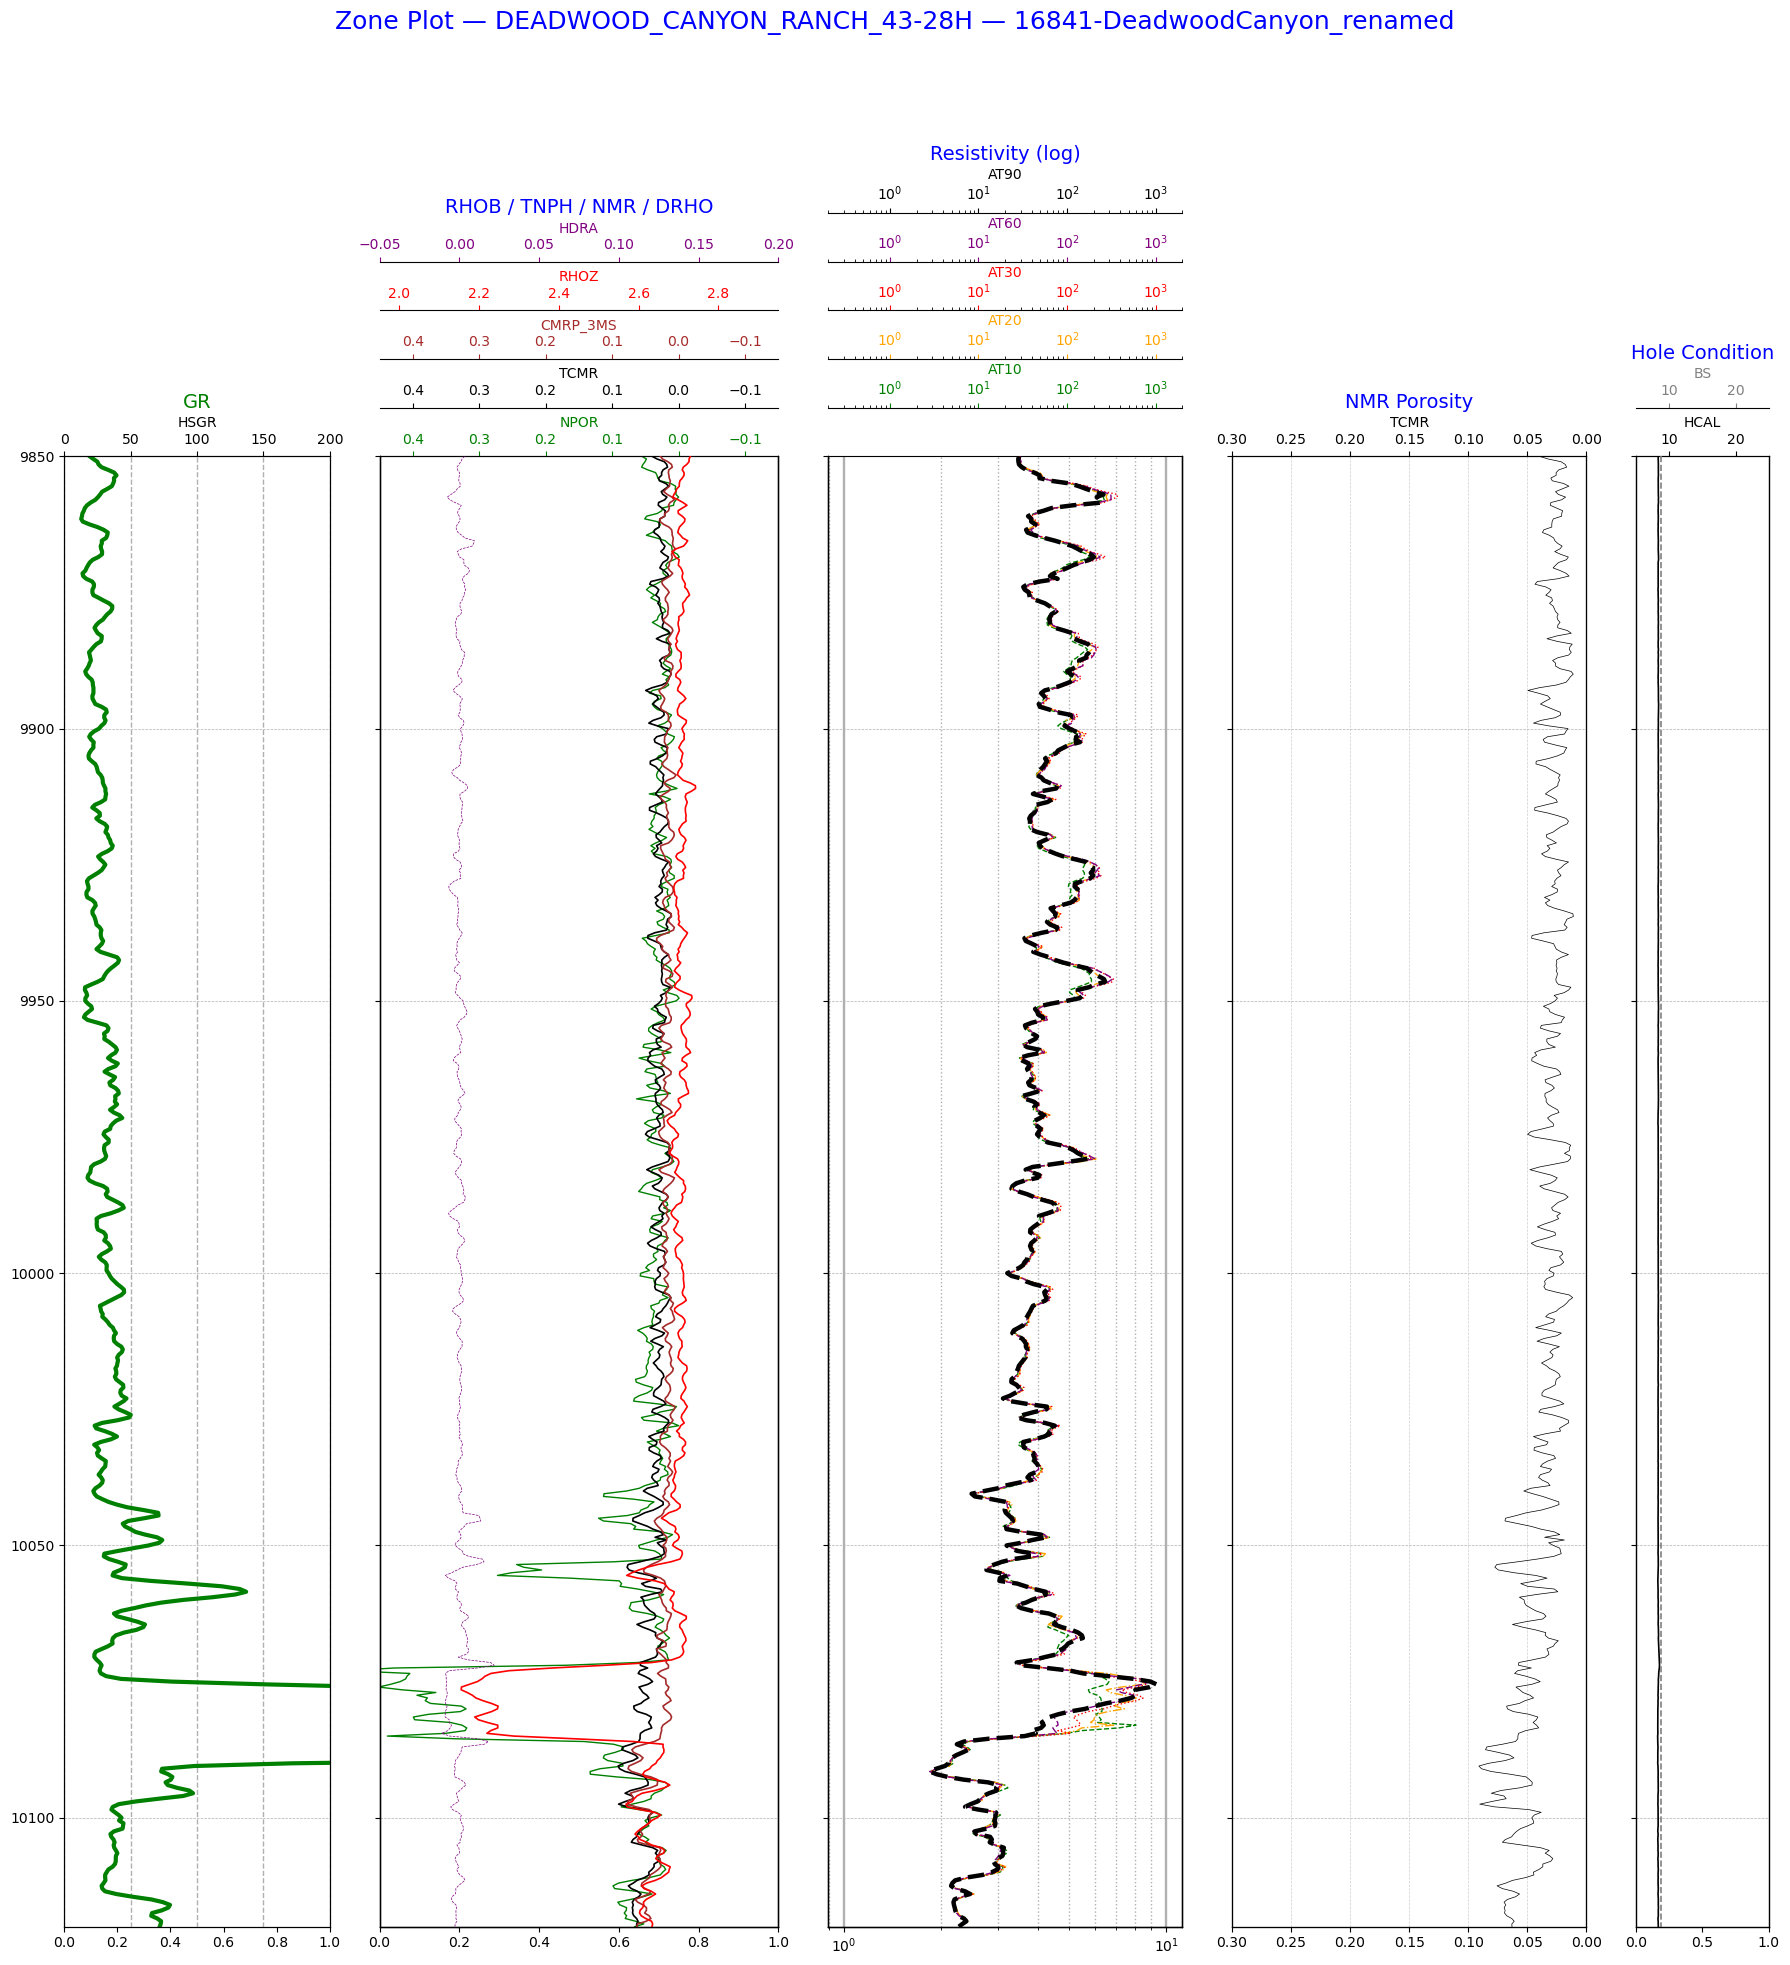

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lasio

# -----------------------------
# USER INPUTS
# -----------------------------
top_summary = 9850
bottom_summary = 10120

# merged LAS filename you already created
# las_filename = f"Merged_Well_Log_{well_name_cleaned}_{file_directory}.las"

# Optional tops
# tops_depths = [...]
# tops = [...]

# -----------------------------
# Helpers
# -----------------------------
def build_units_map(las) -> dict:
    return {(c.mnemonic or "").strip(): (c.unit or "").strip() for c in las.curves}

def nice_label(mnemonic, units_map):
    u = (units_map.get(mnemonic, "") or "").strip()
    return f"{mnemonic}\n[{u}]" if u else mnemonic

def first_present(cols, candidates):
    s = set(cols)
    for c in candidates:
        if c in s:
            return c
    return None

def present_all(cols, candidates):
    s = set(cols)
    return [c for c in candidates if c in s]

def safe_log_limits(series):
    x = np.asarray(series, dtype=float)
    x = x[np.isfinite(x)]
    x = x[x > 0]
    if x.size == 0:
        return 0.2, 200
    lo = np.nanpercentile(x, 5)
    hi = np.nanpercentile(x, 95)
    lo = max(lo, hi/1e4) if hi > 0 else 0.2
    return lo, hi

def add_tops(ax, top_depth, bottom_depth):
    if "tops_depths" in globals() and "tops" in globals():
        for d in tops_depths:
            if top_depth <= d <= bottom_depth:
                ax.axhline(d, color="red", linewidth=1.0)

def add_tops_labels(ax, top_depth, bottom_depth):
    if "tops_depths" in globals() and "tops" in globals():
        for d, nm in zip(tops_depths, tops):
            if top_depth <= d <= bottom_depth:
                ax.text(0.02, d, str(nm),
                        transform=ax.get_yaxis_transform(),
                        ha="left", va="center",
                        color="red", fontsize=10)

# -----------------------------
# Plot function
# -----------------------------
def plot_zone_template(las_path, top_depth, bottom_depth, title=None):
    las = lasio.read(las_path)
    units = build_units_map(las)

    logs = las.df().copy()
    logs.index.name = "DEPT"
    logs = logs.sort_index()

    z = logs.loc[(logs.index >= top_depth) & (logs.index <= bottom_depth)].copy()
    if z.empty:
        raise ValueError(f"No data in zone {top_depth}–{bottom_depth} for {las_path}")

    # Candidate lists (tuned to your discussion)
    gr_cands = ["GR", "HSGR", "SGR"]

    # Track 2
    rhob_cands = ["RHOB", "RHOZ"]
    drho_cands = ["DRHO", "HDRA", "HDRH", "DROH", "DRH", "RHOC"]
    tnph_cands = ["TNPH", "NPHI", "NPOR", "CNL"]
    tcmr_cands = ["TCMR","MPHIS"]
    cmrp_cands = ["CMRP_3MS", "CMRP3MS", "CMRP","MPHI"]

    # Track 3 resistivities (prefer ATxx, but accept AFxx / AExx style variants)
    rxo_cands = ["RXOZ", "Rxo", "RXO", "RxoZ"]
    at90_cands = ["AT90", "AF90", "AO90", "ILD", "RT"]
    at60_cands = ["AT60", "AF60", "AO60"]
    at30_cands = ["AT30", "AF30", "AO30"]
    at20_cands = ["AT20", "AF20", "AO20"]
    at10_cands = ["AT10", "AF10", "AO10"]

    # Track 4 NMR
    bfv_cands = ["BFV", "BFV_3MS", "BFV3MS","MBVI"]

    # Track 5 hole
    cali_cands = ["CALI", "HCAL", "CAL", "CALIPER", "HD1_PPC1", "HD2_PPC1"]
    bs_cands = ["BS", "BITSIZE", "BIT", "BIT_SIZE"]
    dcal_cands = ["DCAL", "DCALI", "D_CAL", "CALD"]

    # Pick curves that exist
    gr = first_present(z.columns, gr_cands)

    rhob = first_present(z.columns, rhob_cands)
    drho = first_present(z.columns, drho_cands)
    tnph = first_present(z.columns, tnph_cands)
    tcmr = first_present(z.columns, tcmr_cands)
    cmrp = first_present(z.columns, cmrp_cands)
    bfv  = first_present(z.columns, bfv_cands)

    rxo = first_present(z.columns, rxo_cands)
    at90 = first_present(z.columns, at90_cands)
    at60 = first_present(z.columns, at60_cands)
    at30 = first_present(z.columns, at30_cands)
    at20 = first_present(z.columns, at20_cands)
    at10 = first_present(z.columns, at10_cands)


    cali = first_present(z.columns, cali_cands)
    bs = first_present(z.columns, bs_cands)
    dcal = first_present(z.columns, dcal_cands)






    
    # Create 5 tracks
    #fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(18, 20), sharey=True)
    fig, ax = plt.subplots(
    nrows=1, ncols=5, figsize=(18, 20), sharey=True,
    gridspec_kw={"width_ratios": [1.2, 1.8, 1.6, 1.6, 0.6]}  # Track 5 skinny
    )





    
    if title is None:
        title = f"Zone Template Plot (Merged) — {top_depth:g}–{bottom_depth:g} ft"
    fig.suptitle(title, fontsize=18, color="blue")
    fig.subplots_adjust(top=0.92, wspace=0.20)

    # Common Y formatting
    for a in ax:
        a.set_ylim(top_depth, bottom_depth)
        a.invert_yaxis()
        a.yaxis.grid(True, linestyle="--", linewidth=0.5)
        a.get_xaxis().set_visible(True)
        add_tops(a, top_depth, bottom_depth)
    add_tops_labels(ax[0], top_depth, bottom_depth)

    # -----------------------------
    # Track 1: GR
    # -----------------------------
    ax[0].set_title("GR", fontsize=14, color='green')
    if gr:
        a = ax[0].twiny()
        a.set_xlim(0, 200)
        a.plot(z[gr].values, z.index.values, color = "green", linewidth=3.0)
        a.set_xlabel(nice_label(gr, units))
        a.grid(True, linestyle="--", linewidth=1)
    else:
        ax[0].text(0.5, 0.5, "No GR", transform=ax[0].transAxes, ha="center", va="center")


    
    # -----------------------------
    # Track 2: RHOB + (TNPH/TCMR/CMRP) + DRHO
    # -----------------------------
    ax[1].set_title("RHOB / TNPH / NMR / DRHO", fontsize=14, color='blue')

    # TNPH axis: 0.45 to -0.15 (invert)
    overlay_done = False
    if tnph:
        a = ax[1].twiny()
        a.set_xlim(-0.15, 0.45)
        a.invert_xaxis()
        a.plot(z[tnph].values, z.index.values, color="green", linewidth=1.0, label=tnph)
        a.set_xlabel(nice_label(tnph, units), color="green")
        a.tick_params(axis="x", colors="green")
        a.spines["top"].set_position(("outward", 0))
        overlay_done = True

    # TCMR on same porosity scale if present
    if tcmr:
        a = ax[1].twiny()
        a.set_xlim(-0.15, 0.45)
        a.invert_xaxis()
        a.plot(z[tcmr].values, z.index.values, color="black", linewidth=1.2, label=tcmr)
        a.set_xlabel(nice_label(tcmr, units), color="black")
        a.tick_params(axis="x", colors="black")
        a.spines["top"].set_position(("outward", 35))
        overlay_done = True

    # CMRP_3MS on same porosity scale if present
    if cmrp:
        a = ax[1].twiny()
        a.set_xlim(-0.15, 0.45)
        a.invert_xaxis()
        a.plot(z[cmrp].values, z.index.values, color="brown", linewidth=1.2, label=cmrp)
        a.set_xlabel(nice_label(cmrp, units), color="brown")
        a.tick_params(axis="x", colors="brown")
        a.spines["top"].set_position(("outward", 70))
        overlay_done = True

    # RHOB axis: 1.95 to 2.95
    if rhob:
        a = ax[1].twiny()
        a.set_xlim(1.95, 2.95)
        a.plot(z[rhob].values, z.index.values, color="red", linewidth=1.2, label=rhob)
        a.set_xlabel(nice_label(rhob, units), color="red")
        a.tick_params(axis="x", colors="red")
        a.spines["top"].set_position(("outward", 105))
        overlay_done = True

    # DRHO axis: default -0.2..0.2 (change if your DRHO is scaled differently)
    if drho:
        a = ax[1].twiny()
        a.set_xlim(-0.05, 0.2)  # <- change to (-2,2) if that matches your data
        a.plot(z[drho].values, z.index.values, color="purple", linewidth=0.5, linestyle="--", alpha=1, label=drho)
        a.set_xlabel(nice_label(drho, units), color="purple")
        a.tick_params(axis="x", colors="purple")
        a.spines["top"].set_position(("outward", 140))
        overlay_done = True

    if not overlay_done:
        ax[1].text(0.5, 0.5, "No RHOB/TNPH/NMR/DRHO", transform=ax[1].transAxes, ha="center", va="center")




    # -----------------------------
    # Track 3: Resistivity family (log scale)
    # -----------------------------
    ax[2].set_title("Resistivity (log)", fontsize=14, color="blue")
    
    # Background log grid (base axis only)
    ax[2].set_xscale("log")
    ax[2].grid(which="major", axis="x", linestyle="-", linewidth=1.7, alpha=1)
    ax[2].grid(which="minor", axis="x", linestyle=":", linewidth=1.0, alpha=1)
    
    res_curves = [
        # label , curve , color   , linestyle        , linewidth , offset
        ("RXO",  rxo,  "blue",   "-",               1.,          0),
        ("AT10", at10, "green",  "--",              1.,         35),
        ("AT20", at20, "orange", "-.",              1.,         70),
        ("AT30", at30, "red",    ":",               1.,        105),
        ("AT60", at60, "purple", (0, (5, 2)),       1.0,        140),
        ("AT90", at90, "black",  "--",               3.2,        175),  # anchor curve
    ]
    
    any_res = False
    
    for label, c, color, ls, lw, off in res_curves:
        if c:
            a = ax[2].twiny()
            a.set_xscale("log")
    
            a.set_xlim(0.2, 2000)   
            
            a.plot(
                z[c].values,
                z.index.values,
                color=color,
                linestyle=ls,
                linewidth=lw
            )
    
            a.set_xlabel(nice_label(c, units), color=color)
            a.tick_params(axis="x", colors=color)
            a.spines["top"].set_position(("outward", off))
            a.grid(False)
    
            any_res = True
    
    if not any_res:
        ax[2].text(
            0.5, 0.5,
            "No resistivity curves",
            transform=ax[2].transAxes,
            ha="center",
            va="center"
        )


    # -----------------------------
    # Track 4: NMR (TCMR/CMRP/BFV) + stacked fills
    # -----------------------------
    ax[3].set_title("NMR Porosity", fontsize=14, color="blue")
    any_nmr = False
    
    x_left, x_right = 0.0, 0.3  # fixed NMR scale (displayed inverted)
    
    # --- Base axis (for consistent x-range/grid if you want it) ---
    ax[3].set_xlim(x_left, x_right)
    ax[3].invert_xaxis()
    ax[3].grid(True, axis="x", linestyle="--", linewidth=0.5, alpha=0.6)
    
    # --- Stacked fills (single twiny so fills align perfectly) ---
    if tcmr or bfv:
        a_fill = ax[3].twiny()
        a_fill.set_xlim(x_left, x_right)
        a_fill.invert_xaxis()
        a_fill.spines["top"].set_visible(False)
        a_fill.get_xaxis().set_visible(False)
        a_fill.grid(False)
    
  
        # Fill TCMR -> BFV (yellow)
        if tcmr and bfv:
            a_fill.fill_betweenx(
                z.index.values,
                z[tcmr].values,
                z[bfv].values,
                facecolor="yellow",
                alpha=1,
                label="TCMR–BFV"
            )
            any_nmr = True
    
        # Fill BFV -> 0 (blue)
        if bfv:
            a_fill.fill_betweenx(
                z.index.values,
                z[bfv].values,
                0.0,
                facecolor="blue",
                alpha=1.0,
                label="BFV–0"
            )
            any_nmr = True
    
    # --- Curves on top (separate twiny axes so labels don't collide) ---
    for   c,    color,   off, lw,  ls in [
        (tcmr, "black",  0,   0.5,  "-"),
        #(cmrp, "black", 35,  1.0,  "-"),
        (bfv,  "black",   70,  1.0,  "-."),
    ]:
        if c:
            a = ax[3].twiny()
            a.set_xlim(x_left, x_right)
            a.invert_xaxis()
            a.plot(z[c].values, z.index.values, color=color, linewidth=lw, linestyle=ls)
            a.set_xlabel(nice_label(c, units), color=color)
            a.tick_params(axis="x", colors=color)
            a.spines["top"].set_position(("outward", off))
            a.grid(False)
            any_nmr = True
    
    if not any_nmr:
        ax[3].text(0.5, 0.5, "No NMR curves", transform=ax[3].transAxes, ha="center", va="center")

  




    # -----------------------------
    # Track 5: Hole Condition (CALI/BS/DCAL) with washout & mudcake shading
    #   - CALI/BS: 5–25 (no reverse)
    #   - DCAL:   -2–+2 (no reverse)
    # -----------------------------
    ax[4].set_title("Hole Condition", fontsize=14, color="blue")
    any_hole = False
    
    # Scales
    cali_min, cali_max = 5.0, 25.0
    dcal_min, dcal_max = -2.0, 2.0
    
    # -----------------------------
    # CALI + BS
    # -----------------------------
    if cali:
        a = ax[4].twiny()
        a.set_xlim(cali_min, cali_max)
        a.plot(z[cali].values, z.index.values, color="black", linewidth=1.2)
        a.set_xlabel(nice_label(cali, units), color="black")
        a.tick_params(axis="x", colors="black")
        a.spines["top"].set_position(("outward", 0))
        a.grid(False)
        any_hole = True
    
    if bs:
        a = ax[4].twiny()
        a.set_xlim(cali_min, cali_max)
        a.plot(z[bs].values, z.index.values, color="gray", linewidth=1.2, linestyle="--")
        a.set_xlabel(nice_label(bs, units), color="gray")
        a.tick_params(axis="x", colors="gray")
        a.spines["top"].set_position(("outward", 35))
        a.grid(False)
        any_hole = True
    
    # Optional washout fill between CALI and BS (only where CALI > BS)
    if cali and bs:
        cali_vals = z[cali].astype(float).values
        bs_vals   = z[bs].astype(float).values
        depth     = z.index.values
    
        a_fill_cali = ax[4].twiny()
        a_fill_cali.set_xlim(cali_min, cali_max)
        a_fill_cali.spines["top"].set_visible(False)
        a_fill_cali.get_xaxis().set_visible(False)
        a_fill_cali.grid(False)
    
        # Washout where CALI > BS
        a_fill_cali.fill_betweenx(
            depth,
            bs_vals,
            cali_vals,
            where=np.isfinite(cali_vals) & np.isfinite(bs_vals) & (cali_vals > bs_vals),
            facecolor="yellow",
            alpha=0.25
        )
    
    # -----------------------------
    # DCAL with signed shading
    #   - DCAL > 0: washout (yellow)
    #   - DCAL < 0: mudcake (brown)
    # -----------------------------
    if dcal:
        DC = z[dcal].astype(float).values
        depth = z.index.values
    
        # Fill axis (hidden)
        a_fill = ax[4].twiny()
        a_fill.set_xlim(dcal_min, dcal_max)
        a_fill.spines["top"].set_visible(False)
        a_fill.get_xaxis().set_visible(False)
        a_fill.grid(False)
    
        # Washout: from 0 to +DCAL (only where DCAL > 0)
        a_fill.fill_betweenx(
            depth,
            0.0,
            np.clip(DC, 0.0, None),
            where=np.isfinite(DC) & (DC > 0),
            facecolor="yellow",
            alpha=0.45
        )
    
        # Mudcake: from DCAL to 0 (only where DCAL < 0)
        a_fill.fill_betweenx(
            depth,
            np.clip(DC, None, 0.0),
            0.0,
            where=np.isfinite(DC) & (DC < 0),
            facecolor="saddlebrown",
            alpha=0.45
        )
    
        # DCAL curve on top (dashed)
        a = ax[4].twiny()
        a.set_xlim(dcal_min, dcal_max)
        a.plot(DC, depth, color="purple", linewidth=1.3, linestyle="--")
        a.set_xlabel(nice_label(dcal, units), color="purple")
        a.tick_params(axis="x", colors="purple")
        a.spines["top"].set_position(("outward", 70))
        a.grid(False)
    
        any_hole = True
    
    if not any_hole:
        ax[4].text(0.5, 0.5, "No CALI / BS / DCAL", transform=ax[4].transAxes, ha="center", va="center")
    
    











    
    
    plt.tight_layout(rect=[0, 0, 1, 0.94])
    return fig

# -----------------------------
# RUN IT
# -----------------------------
fig = plot_zone_template(
    las_filename,
    top_summary,
    bottom_summary,
    title=f"Zone Plot — {well_name_cleaned} — {file_directory}"
)
plt.show()


---
---
# Experimental where we add DRHO and DCAL data:

Run                                               File CALI used BS used  \
0    1  ./16841-DeadwoodCanyon_renamed/01_TCOMBO_AIG-C...      HCAL    None   
1    2  ./16841-DeadwoodCanyon_renamed/02_ECS_ECS_MAIN...      None    None   
2    3  ./16841-DeadwoodCanyon_renamed/03_SONIC_AIG-CN...  HD1_PPC1      BS   
3    4  ./16841-DeadwoodCanyon_renamed/04_SPECTRAL_SPL...      None      BS   
4    5  ./16841-DeadwoodCanyon_renamed/05_CMR_MRI_CMR_...      None      BS   

  DRHO chosen DCAL chosen  DCAL_CALC available      DCAL_CALC_FROM  
0        HDRA        None                False        (None, None)  
1        None        None                False        (None, None)  
2        None   DCAL_CALC                 True  ('HD1_PPC1', 'BS')  
3        None        None                False        (None, None)  
4        None        None                False        (None, None)

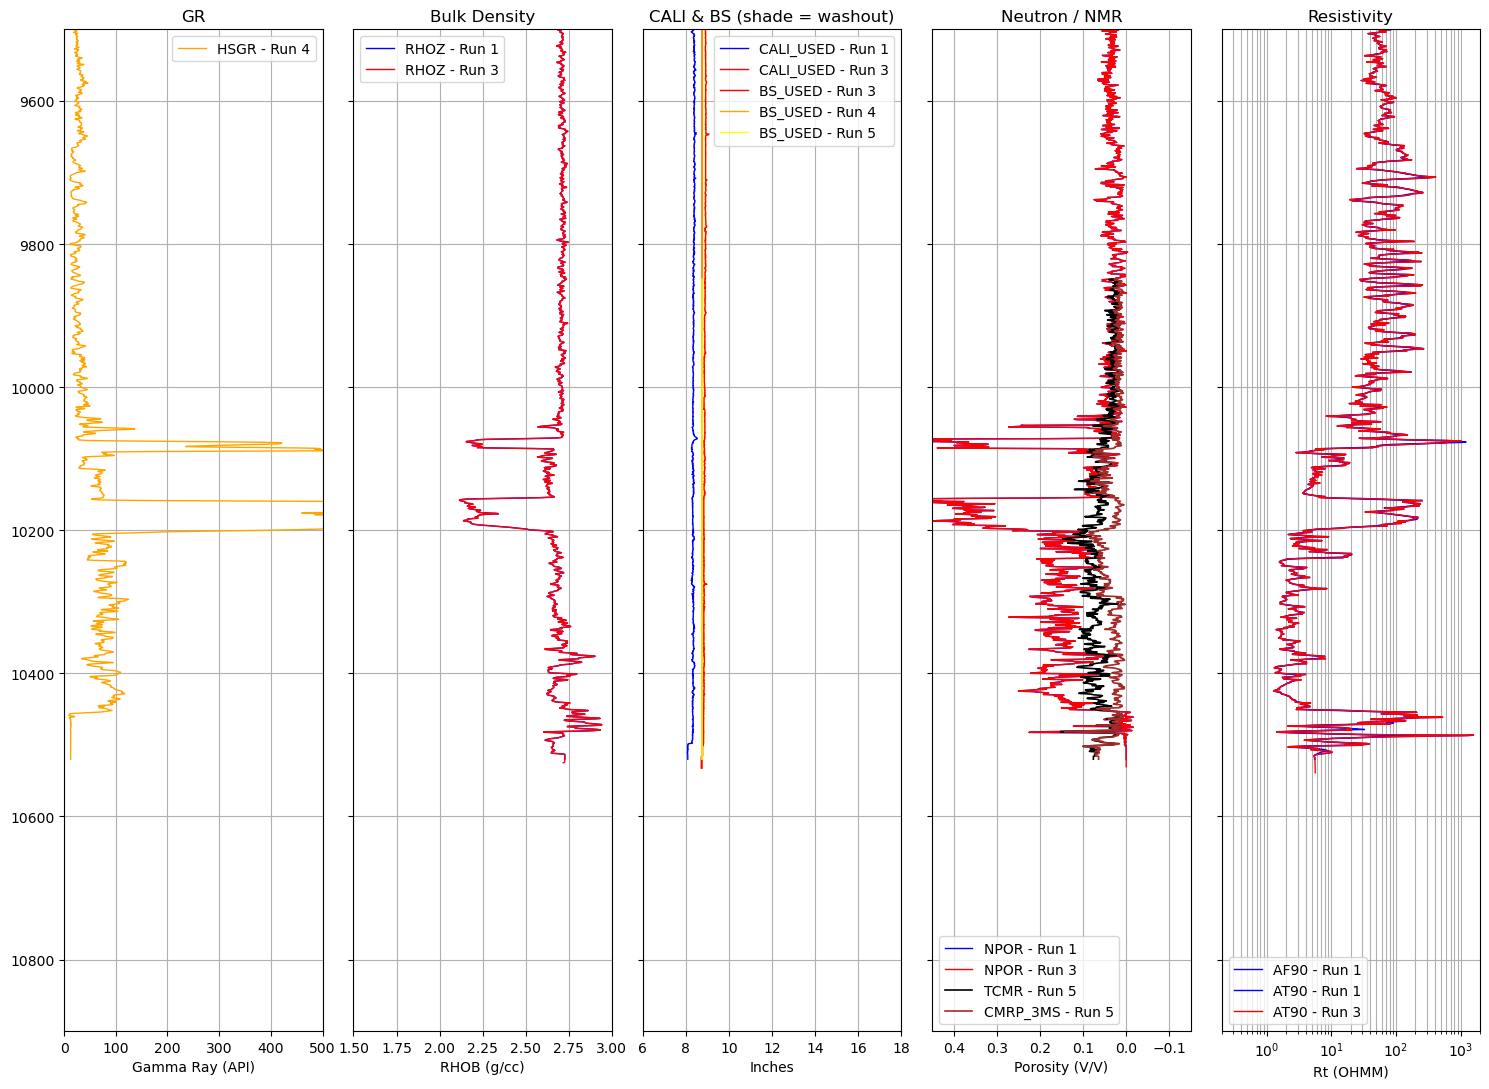

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lasio


# -----------------------------
# 1) Define curve families
# -----------------------------
curve_families = {
    "GR":      ["GR", "HSGR", "SGR"],

    "RHOB":    ["RHOB", "RHOZ"],
    "DRHO":    ["DRHO", "HDRA", "HDRH"],

    # Bit size (inches)
    "BS":      ["BS", "BITSIZE", "BIT", "BIT_SIZE"],

    # Caliper (hole diameter, inches)
    "CALI":    ["HD1_PPC1", "HD2_PPC1", "CALI", "HCAL", "C1", "C2"],

    # DCAL: prefer provided DCAL, else computed DCAL_CALC
    "DCAL":    ["DCAL", "DCAL_CALC"],

    "TNPH":    ["TNPH", "NPHI", "NPOR", "CNL"],
    "POR_NMR": ["TCMR", "CMRP_3MS", "BFV"],

    # Resistivity (log10)
    "RT":      ["RT", "AF90", "AT90", "AO90"],

    # Permeability (mD, log10)
    "PERM":    ["PERM", "K", "KH", "KVERT", "KMD", "PERM_MD", "PERM_M", "KLOGH", "KLOG", "KTIM", "KSDR"],
}

# -----------------------------
# Optional per-curve styling
# -----------------------------
curve_style = {
    "RHOB": {"color": "black", "linewidth": 1.2},
    "DRHO": {"color": "red",   "linewidth": 1.0},

    "BS":   {"color": "black",  "linewidth": 1.2},
    "CALI": {"color": "blue",   "linewidth": 1.0},

    "DCAL":      {"color": "purple", "linewidth": 1.0},
    "DCAL_CALC": {"color": "purple", "linewidth": 1.0, "linestyle": "--"},

    "TCMR":     {"color": "black", "linewidth": 1.2},
    "CMRP_3MS": {"color": "brown", "linewidth": 1.2},
    "BFV":      {"color": "blue",  "linewidth": 1.2},
}

# -----------------------------
# Fill specs
# -----------------------------
fill_between_por = {
    "track": "POR_NMR",
    "left": "TCMR",
    "right": "BFV",
    "color": "yellow",
    "alpha": 0.35
}

# NEW: Yellow fill between BS and CALI
fill_between_cali = {
    "track": "CALI_BS",
    "left": "BS_USED",      # computed per-run alias
    "right": "CALI_USED",   # computed per-run alias
    "color": "yellow",
    "alpha": 0.25
}

# -----------------------------
# Family axis scale defaults
# -----------------------------
family_plot_config = {
    "RT":   {"xscale": "log"},
    "PERM": {"xscale": "log"},
}

# -----------------------------
# 2) Read LAS files
# -----------------------------
logs = []
for file in las_files:
    las = lasio.read(file)

    curve_info = {
        curve.mnemonic: (las[curve.mnemonic].min(), las[curve.mnemonic].max())
        for curve in las.curves
    }

    data = {
        "file": file,
        "depth": las["DEPT"],
        "depth_min": top_depth,
        "depth_max": bottom_depth,
        "curves": curve_info
    }

    # Load only mnemonics we care about (exclude computed placeholders)
    needed = set(mn for fam in curve_families.values() for mn in fam if mn not in {"DCAL_CALC"})
    for mn in needed:
        data[mn] = las[mn] if mn in las.curves else None

    # Placeholders for computed / chosen curves
    data["DCAL_CALC"] = None
    data["DCAL_CALC_FROM"] = (None, None)

    data["BS_USED"] = None
    data["BS_USED_MNEMONIC"] = None
    data["CALI_USED"] = None
    data["CALI_USED_MNEMONIC"] = None

    logs.append(data)

# -----------------------------
# 3) Helpers
# -----------------------------
def pick_first_available(log, family_key):
    """Return (mnemonic, array) for the first available curve in a family."""
    for mn in curve_families.get(family_key, []):
        if log.get(mn) is not None:
            return mn, np.asarray(log[mn], float)
    return None, None

# -----------------------------
# 4) Choose CALI and BS + compute DCAL_CALC
# -----------------------------
for log in logs:
    cali_mn, cali = pick_first_available(log, "CALI")
    bs_mn, bs     = pick_first_available(log, "BS")

    # Save chosen CALI/BS under consistent internal names so fill can work
    if cali is not None:
        log["CALI_USED"] = np.asarray(cali, float)
        log["CALI_USED_MNEMONIC"] = cali_mn

    if bs is not None:
        log["BS_USED"] = np.asarray(bs, float)
        log["BS_USED_MNEMONIC"] = bs_mn

    # Compute DCAL_CALC = CALI - BS
    if (cali is not None) and (bs is not None):
        log["DCAL_CALC"] = np.asarray(cali, float) - np.asarray(bs, float)
        log["DCAL_CALC_FROM"] = (cali_mn, bs_mn)

# -----------------------------
# 5) Summary table
# -----------------------------
rows = []
for i, log in enumerate(logs, start=1):
    dcal_mn, _ = pick_first_available(log, "DCAL")  # prefers DCAL, else DCAL_CALC
    drho_mn, _ = pick_first_available(log, "DRHO")

    rows.append({
        "Run": i,
        "File": log["file"],
        "CALI used": log.get("CALI_USED_MNEMONIC"),
        "BS used": log.get("BS_USED_MNEMONIC"),
        "DRHO chosen": drho_mn,
        "DCAL chosen": dcal_mn,
        "DCAL_CALC available": log["DCAL_CALC"] is not None,
        "DCAL_CALC_FROM": str(log["DCAL_CALC_FROM"])
    })

display(pd.DataFrame(rows))

# -----------------------------
# 6) Plot helpers
# -----------------------------
def plot_track(ax, track_keys, xlim=None, xscale=None, xlabel="", title=""):
    #colors = ["blue", "green", "red", "orange", "purple", "cyan", "gray", "teal"]
    colors = ["blue", "green", "red", "orange", "yellow", "black","purple","cyan","gray","violet","limegreen","teal"]

    if isinstance(track_keys, str):
        track_keys = [track_keys]

    # Infer xscale from family if not explicitly provided
    if xscale is None:
        for k in track_keys:
            cfg = family_plot_config.get(k, {})
            if "xscale" in cfg:
                xscale = cfg["xscale"]
                break

    # Expand requested families to their candidate mnemonics
    mnemonics = []
    for key in track_keys:
        mnemonics.extend(curve_families.get(key, []))

    # Also allow direct mnemonics (e.g., "BS_USED", "CALI_USED")
    # If user passed something not in curve_families, treat as a mnemonic itself.
    for key in track_keys:
        if key not in curve_families and key not in mnemonics:
            mnemonics.append(key)

    for i, log in enumerate(logs):
        depth = np.asarray(log["depth"], float)

        for mn in mnemonics:
            if log.get(mn) is None:
                continue

            x = np.asarray(log[mn], float)

            if xscale == "log":
                m = (
                    np.isfinite(depth) &
                    np.isfinite(x) &
                    (x > 0) &
                    (depth >= top_depth) &
                    (depth <= bottom_depth)
                )
            else:
                m = (
                    np.isfinite(depth) &
                    np.isfinite(x) &
                    (depth >= top_depth) &
                    (depth <= bottom_depth)
                )

            if not np.any(m):
                continue

            style = {"color": colors[i % len(colors)], "linewidth": 1.0}
            if mn in curve_style:
                style.update(curve_style[mn])

            ax.plot(x[m], depth[m], label=f"{mn} - Run {i+1}", **style)

    ax.set_ylim(top_depth, bottom_depth)
    ax.invert_yaxis()
    if xlim is not None:
        ax.set_xlim(*xlim)
    if xscale is not None:
        ax.set_xscale(xscale)
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    ax.grid(True, which="both")
    ax.legend()

def add_fill_between(ax, left_key, right_key, color="yellow", alpha=0.25):
    """
    Fill between two curve keys (mnemonics) that exist in each log dict.
    """
    for log in logs:
        if log.get(left_key) is None or log.get(right_key) is None:
            continue

        depth = np.asarray(log["depth"], float)
        x1 = np.asarray(log[left_key], float)
        x2 = np.asarray(log[right_key], float)

        m = (
            (depth >= top_depth) &
            (depth <= bottom_depth) &
            np.isfinite(x1) &
            np.isfinite(x2)
        )

        if np.any(m):
            ax.fill_betweenx(depth[m], x1[m], x2[m], color=color, alpha=alpha)

# -----------------------------
# 7) Plot function
# -----------------------------
def plot_well_logs():
    # 5 tracks: GR | RHOB | BS/CALI | TNPH/NMR | RT
    fig, axes = plt.subplots(1, 5, figsize=(15, 11), sharey=True)

    # Track 1: GR
    plot_track(
        axes[0],
        "GR",
        xlim=(0, 500),
        xlabel="Gamma Ray (API)",
        title="GR"
    )

    # Track 2: RHOB
    plot_track(
        axes[1],
        "RHOB",
        xlim=(1.5, 3.0),
        xlabel="RHOB (g/cc)",
        title="Bulk Density"
    )

    # Track 3: CALI + BS with yellow fill
    # NOTE: xlim may need tuning once you see your typical caliper/bit ranges.
    plot_track(
        axes[2],
        ["CALI_USED", "BS_USED"],
        xlim=(6, 18),
        xlabel="Inches",
        title="CALI & BS (shade = washout)"
    )
    add_fill_between(
        axes[2],
        left_key="BS_USED",
        right_key="CALI_USED",
        color=fill_between_cali["color"],
        alpha=fill_between_cali["alpha"]
    )

    # Track 4: Neutron + NMR (with fill)
    plot_track(
        axes[3],
        ["TNPH", "POR_NMR"],
        xlim=(0.45, -0.15),
        xlabel="Porosity (V/V)",
        title="Neutron / NMR"
    )
    add_fill_between(
        axes[3],
        left_key=fill_between_por["left"],
        right_key=fill_between_por["right"],
        color=fill_between_por["color"],
        alpha=fill_between_por["alpha"]
    )

    # Track 5: Resistivity
    plot_track(
        axes[4],
        "RT",
        xlim=(0.2, 2000),
        xlabel="Rt (OHMM)",
        title="Resistivity"
    )

    plt.tight_layout()
    plt.show()

# Execute
plot_well_logs()


## Plot Data from Merged files:

Plot saved as _16841-DeadwoodCanyon_renamed_Merged_Well_Log_Plot_DEADWOOD_CANYON_RANCH_43-28H_16841-DeadwoodCanyon_renamed_blueline_QC-check_on_merged_files.png



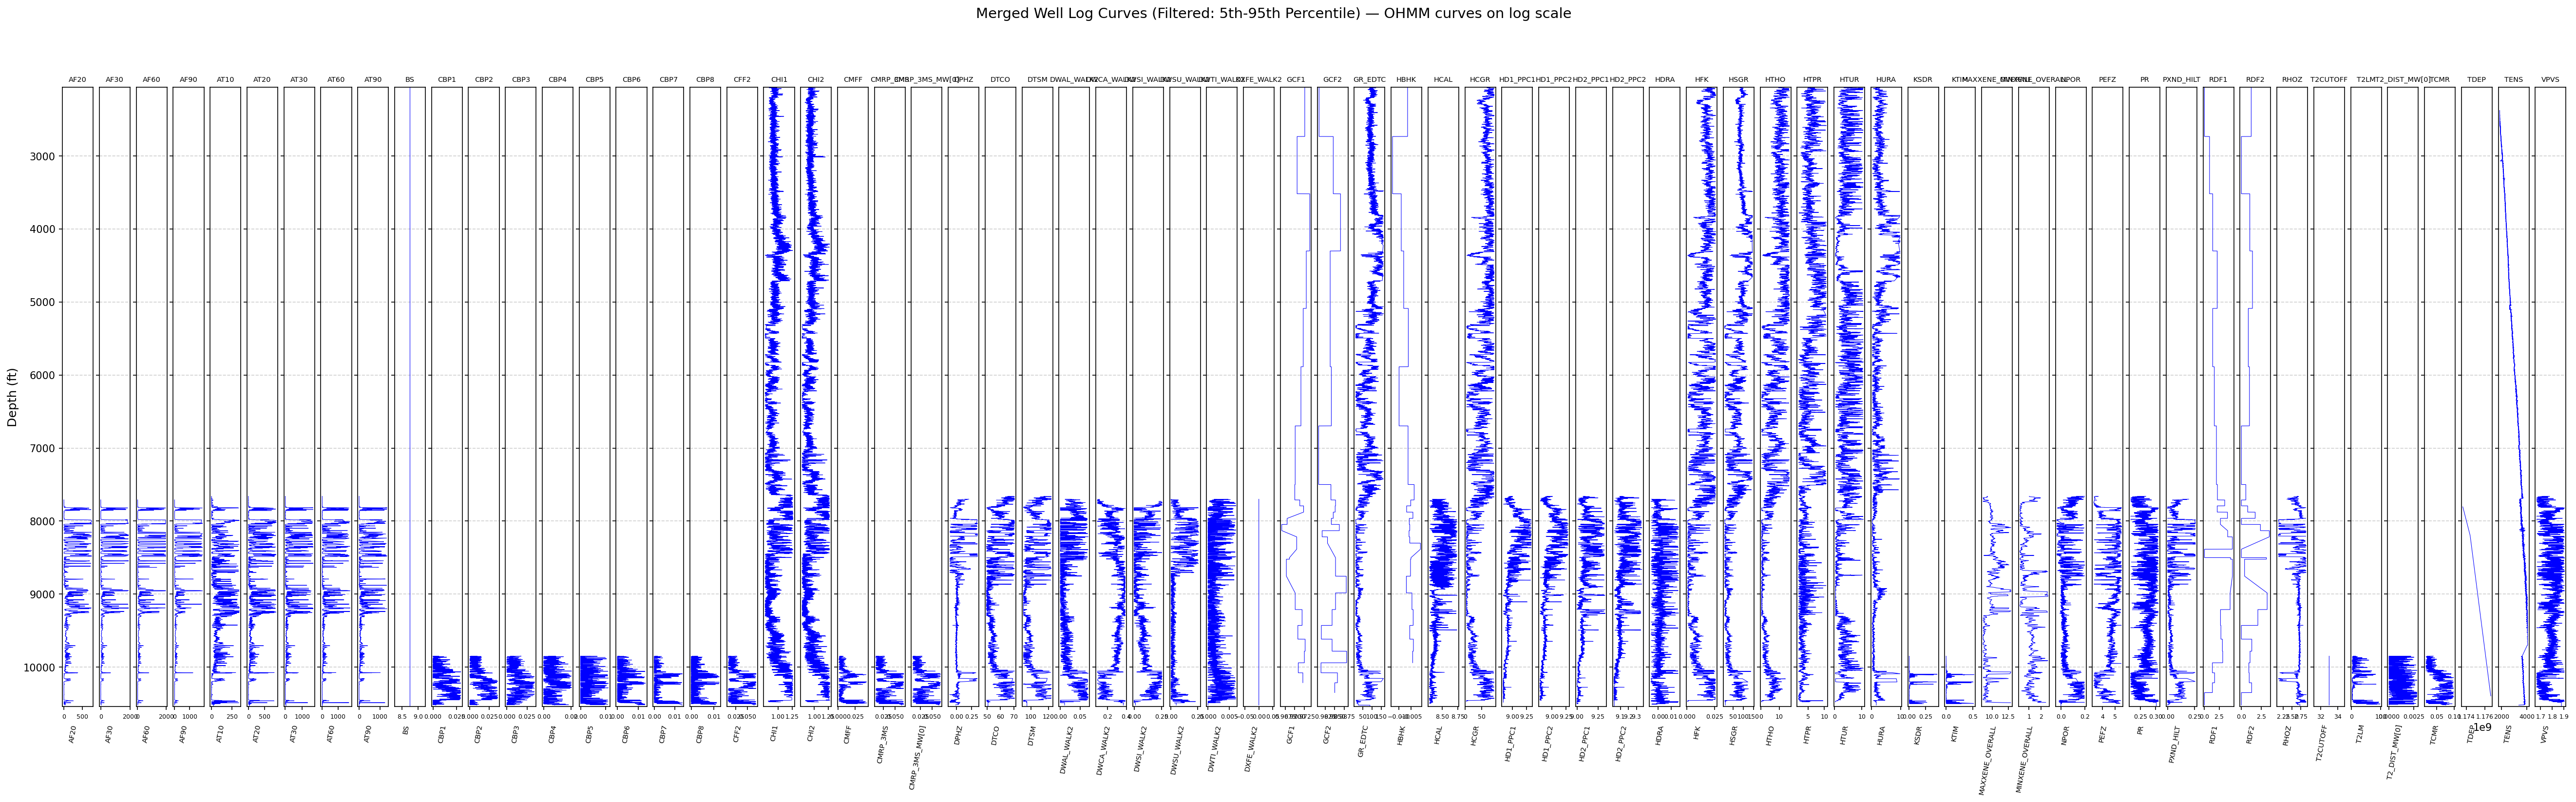

In [13]:
import numpy as np
import pandas as pd
import lasio
import matplotlib.pyplot as plt
from io import BytesIO
import base64
from IPython.display import display, HTML

# Load the merged LAS file
# merged_las = lasio.read("Merged_Well_Log.las")
merged_las = lasio.read(las_filename)

# Extract depth and log curves
depth = np.asarray(merged_las["DEPT"], float)
log_curves = [c.mnemonic for c in merged_las.curves if c.mnemonic != "DEPT"]

# Units map (mnemonic -> unit)
units_map = {c.mnemonic: (c.unit or "") for c in merged_las.curves}

def is_ohmm_curve(curve_name: str, units_map: dict) -> bool:
    u = (units_map.get(curve_name, "") or "").strip().upper().replace(" ", "")
    return any(tok in u for tok in ["OHMM", "OHM.M", "OHM-M", "OHM/M"])

def safe_log_mask(x: np.ndarray) -> np.ndarray:
    return np.isfinite(x) & (x > 0)

# Convert to DataFrame
df_log = merged_las.df()
df_log.index = depth  # Set depth as index

# Calculate 5th and 95th percentiles for filtering
lower_bounds = df_log.quantile(0.05)
upper_bounds = df_log.quantile(0.95)

# Filter out extreme values
df_filtered = df_log.apply(
    lambda col: col.where((col >= lower_bounds[col.name]) & (col <= upper_bounds[col.name]), np.nan),
    axis=0
)

# Global depth limits (if you already have min_depth/max_depth defined, you can use those)
min_depth = float(np.nanmin(depth))
max_depth = float(np.nanmax(depth))

# Create figure with tracks for all curves
fig, axes = plt.subplots(
    nrows=1,
    ncols=len(log_curves),
    figsize=(len(log_curves) * 0.65, 11),
    sharey=True
)

# If only one curve, axes is not a list; normalize
if len(log_curves) == 1:
    axes = [axes]

# Loop through each well log curve and plot it
for i, curve in enumerate(log_curves):
    ax = axes[i]
    ax.set_title(curve, fontsize=7)

    curve_is_log = is_ohmm_curve(curve, units_map)

    if curve in df_filtered.columns and df_filtered[curve].notna().any():
        x = df_filtered[curve].to_numpy(dtype=float)
        y = depth

        if curve_is_log:
            m = safe_log_mask(x) & np.isfinite(y)
            if np.any(m):
                ax.plot(x[m], y[m], linewidth=0.5, color="blue", label="Merged Data")
                ax.set_xscale("log")
                ax.grid(True, which="both", axis="x", linestyle=":", alpha=0.35)
        else:
            m = np.isfinite(x) & np.isfinite(y)
            if np.any(m):
                ax.plot(x[m], y[m], linewidth=0.5, color="blue", label="Merged Data")

    # Formatting each subplot
    ax.set_ylim(max_depth, min_depth)  # depth increases downward
    ax.set_xlabel(curve, fontsize=7, rotation=80, ha="right")
    ax.tick_params(axis="x", labelsize=6)
    ax.grid(axis="y", linestyle="--", alpha=0.6)

# Formatting
axes[0].set_ylabel("Depth (ft)", fontsize=12)
fig.suptitle("Merged Well Log Curves (Filtered: 5th-95th Percentile) — OHMM curves on log scale", fontsize=14)

# Save the image
image_filename = f"Merged_Well_Log_Plot_{well_name_cleaned}_{file_directory}_blueline_QC-check_on_merged_files.png"
fig.savefig(image_filename, format="png", dpi=300, bbox_inches="tight")
print(f"Plot saved as _{file_directory}_{image_filename}")

# Convert figure to PNG and encode in base64
buffer = BytesIO()
fig.savefig(buffer, format="png", bbox_inches="tight", dpi=150)
buffer.seek(0)
encoded_image = base64.b64encode(buffer.read()).decode("utf-8")
buffer.close()
plt.close(fig)

# Embed the image inside an HTML scrollable div (keeps everything in the notebook)
html_code = f"""
<div style="width: 100%; overflow-x: auto; border: 1px solid black; white-space: nowrap; padding: 10px;">
    <img src="data:image/png;base64,{encoded_image}" style="max-width: none;"/>
</div>
"""
display(HTML(html_code))


---
---
---
---
# **Compute Badhole flags and flag outlier on merged data.**



DCAL source: computed (CALI - BS)
DRHO curve used: HDRA
Percent BADHOLE_ANY:  0.01%
Percent BADHOLE_DCAL: 0.00%
Percent BADHOLE_DRHO: 0.01%


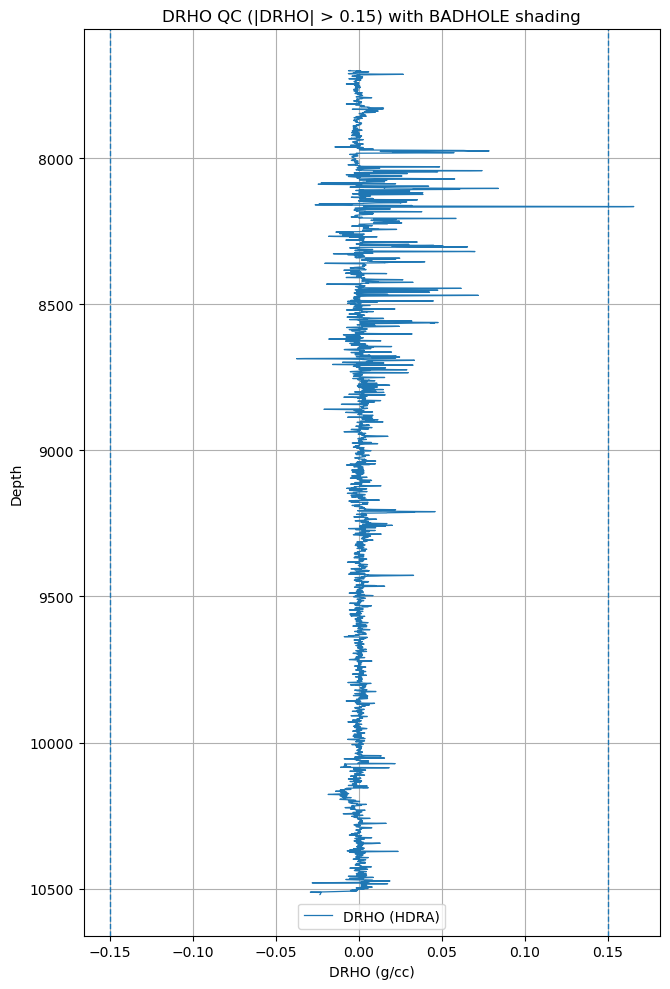

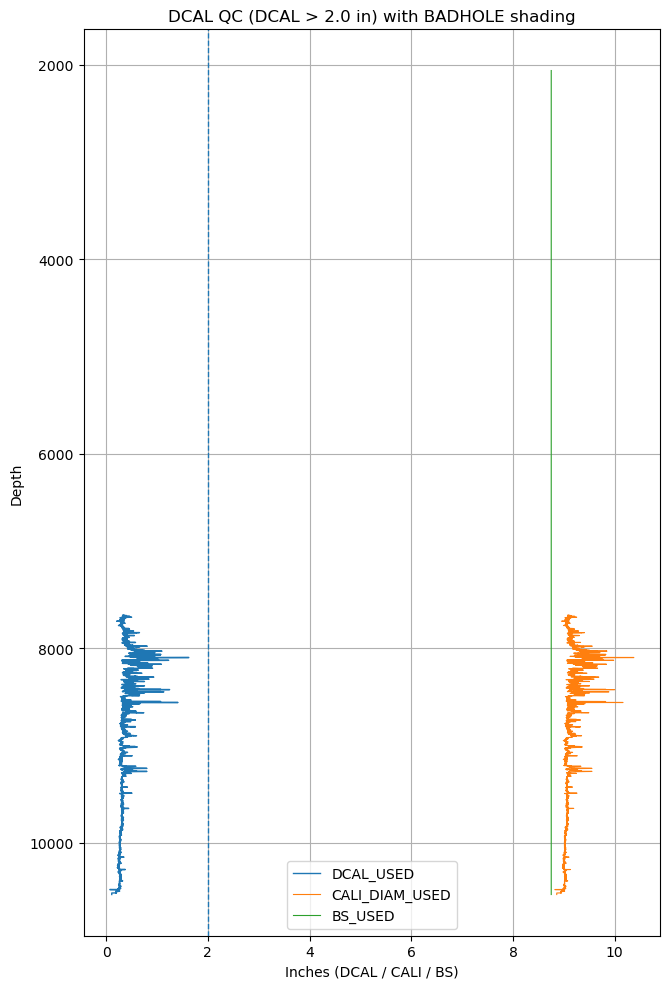

In [14]:
import numpy as np
import pandas as pd
import lasio
import matplotlib.pyplot as plt

# ============================================================
# Load MERGED well log (change filename to your merged output)
# ============================================================
merged_las = lasio.read(las_filename)


# DataFrame of curves; lasio uses depth as index by default
df = merged_las.df().copy()

# Make column names robust (strip whitespace)
df.columns = [str(c).strip() for c in df.columns]

# Depth array for plotting / masks
depth = df.index.to_numpy(dtype=float)

# ============================================================
# Curve families (merged-file logic only)
# ============================================================
curve_families = {
    "GR":      ["GR", "HSGR", "SGR"],
    "RHOB":    ["RHOB", "RHOZ"],
    "DRHO":    ["DRHO", "DRO", "RHOC", "RHO_COR", "RHO_CORR", "RHOCOR","DENC", 
                "DENCOR", "DEN_COR", "DEN_CORR","ZCOR", "ZCORR","HDRA", "HDRH", "ECOR", "DCOR"],
    "BS":      ["BS", "BITSIZE", "BIT", "BIT_SIZE"],

    # Caliper (hole diameter, inches) — prefer the full-coverage HD curves first
    "CALI":    ["HD1_PPC1", "HD2_PPC1", "CALI", "HCAL", "C1", "C2"],

    "DCAL":    ["DCAL"],
    "TNPH":    ["TNPH", "NPHI", "NPOR", "CNL"],
    "POR_NMR": ["TCMR", "CMRP_3MS", "BFV"],
    "RT":      ["RT", "AF90", "AT90", "AO90"],
}

# ============================================================
# Helper functions
# ============================================================
def _norm(s: str) -> str:
    return str(s).strip().upper()

def get_col_ci(df, candidates):
    """Case-insensitive + whitespace-safe column fetch. Returns actual column name or None."""
    colmap = {_norm(c): c for c in df.columns}
    for mn in candidates:
        key = _norm(mn)
        if key in colmap:
            col = colmap[key]
            if df[col].notna().any():
                return col
    return None

def get_header_constant(las, keys):
    """Try to pull a constant from LAS header (WELL/Parameter blocks). Returns float or None."""
    for k in keys:
        kk = k.strip().upper()

        # WELL block
        try:
            if kk in las.well:
                v = las.well[kk].value
                v = float(v)
                if np.isfinite(v):
                    return v
        except Exception:
            pass

        # PARAMETER block
        try:
            if hasattr(las, "params") and kk in las.params:
                v = las.params[kk].value
                v = float(v)
                if np.isfinite(v):
                    return v
        except Exception:
            pass

    return None

def build_caliper_diameter(df):
    """
    Returns a Series of hole diameter in inches.
    If both HD1_PPC1 and HD2_PPC1 exist, returns max(HD1, HD2) at each depth.
    Else returns first available caliper curve.
    """
    hd1 = get_col_ci(df, ["HD1_PPC1"])
    hd2 = get_col_ci(df, ["HD2_PPC1"])

    if hd1 is not None and hd2 is not None:
        a = pd.to_numeric(df[hd1], errors="coerce")
        b = pd.to_numeric(df[hd2], errors="coerce")
        return pd.concat([a, b], axis=1).max(axis=1)

    cali_col = get_col_ci(df, curve_families["CALI"])
    if cali_col is None:
        return None
    return pd.to_numeric(df[cali_col], errors="coerce")

def build_bit_size(df, las):
    """
    Returns a Series of BS (bit size) in inches.
    Uses BS curve if present; else tries header constants; else None.
    """
    bs_col = get_col_ci(df, curve_families["BS"])
    if bs_col is not None:
        return pd.to_numeric(df[bs_col], errors="coerce")

    bs_const = get_header_constant(las, ["BS", "BIT", "BITSIZE", "BIT_SIZE"])
    if bs_const is None:
        return None

    return pd.Series(bs_const, index=df.index, dtype=float)

def build_dcal(df, las, cali_diam, bs):
    """
    Returns (dcal_series, source_str)
    Prefers DCAL curve; else computes CALI - BS.
    """
    dcal_col = get_col_ci(df, curve_families["DCAL"])
    if dcal_col is not None:
        return pd.to_numeric(df[dcal_col], errors="coerce"), f"DCAL curve ({dcal_col})"

    if cali_diam is not None and bs is not None:
        return (cali_diam - bs), "computed (CALI - BS)"

    return None, "missing (no DCAL and cannot compute CALI - BS)"

# ============================================================
# Build merged-file derived curves: CALI_DIAM, BS_USED, DCAL_USED
# ============================================================
cali_diam = build_caliper_diameter(df)
bs_used   = build_bit_size(df, merged_las)
dcal_used, dcal_src = build_dcal(df, merged_las, cali_diam, bs_used)

# Add to df for downstream work
df["CALI_DIAM_USED"] = cali_diam
df["BS_USED"]        = bs_used
df["DCAL_USED"]      = dcal_used

# ============================================================
# Badhole thresholds (tune here)
# ============================================================
DCAL_CUTOFF_IN   = 2.0     # washout threshold (inches)
DRHO_CUTOFF_GCC  = 0.15    # density correction magnitude threshold (g/cc)

# Get DRHO
drho_col = get_col_ci(df, curve_families["DRHO"])
drho = pd.to_numeric(df[drho_col], errors="coerce") if drho_col is not None else None

# ============================================================
# Component badhole flags (merged file)
# ============================================================
df["BADHOLE_DCAL"] = False
df["BADHOLE_DRHO"] = False

if dcal_used is not None:
    df["BADHOLE_DCAL"] = (dcal_used > DCAL_CUTOFF_IN)

if drho is not None:
    df["BADHOLE_DRHO"] = (drho.abs() > DRHO_CUTOFF_GCC)

df["BADHOLE_ANY"] = (df["BADHOLE_DCAL"] | df["BADHOLE_DRHO"])

print(f"DCAL source: {dcal_src}")
print(f"DRHO curve used: {drho_col}")
print(f"Percent BADHOLE_ANY:  {100.0*df['BADHOLE_ANY'].mean():.2f}%")
print(f"Percent BADHOLE_DCAL: {100.0*df['BADHOLE_DCAL'].mean():.2f}%")
print(f"Percent BADHOLE_DRHO: {100.0*df['BADHOLE_DRHO'].mean():.2f}%")

# ============================================================
# Plot helpers (multi-color badhole shading)
# ============================================================
def shade_mask(ax, depth, mask, color, alpha=0.18, zorder=0):
    """Shade contiguous depth intervals where mask is True."""
    mask = np.asarray(mask, dtype=bool)
    if not mask.any():
        return

    in_band = False
    z0 = None
    for i in range(len(mask)):
        if mask[i] and not in_band:
            in_band = True
            z0 = depth[i]
        elif (not mask[i]) and in_band:
            in_band = False
            z1 = depth[i-1]
            ax.axhspan(min(z0, z1), max(z0, z1),
                       color=color, alpha=alpha, linewidth=0, zorder=zorder)
    if in_band:
        ax.axhspan(min(z0, depth[-1]), max(z0, depth[-1]),
                   color=color, alpha=alpha, linewidth=0, zorder=zorder)

# ============================================================
# Plot 1: DRHO QC + shading
#   blue   = BADHOLE_ANY
#   red    = BADHOLE_DRHO
# ============================================================
fig, ax = plt.subplots(1, 1, figsize=(6.8, 10))

shade_mask(ax, depth, df["BADHOLE_ANY"].values,  color="dodgerblue", alpha=0.32, zorder=0)
shade_mask(ax, depth, df["BADHOLE_DRHO"].values, color="red",       alpha=0.58, zorder=1)

if drho is not None and drho.notna().any():
    ax.plot(drho, depth, linewidth=0.9, label=f"DRHO ({drho_col})", zorder=3)
    ax.axvline(+DRHO_CUTOFF_GCC, linewidth=1.0, linestyle="--", zorder=2)
    ax.axvline(-DRHO_CUTOFF_GCC, linewidth=1.0, linestyle="--", zorder=2)

ax.invert_yaxis()
ax.set_xlabel("DRHO (g/cc)")
ax.set_ylabel("Depth")
ax.set_title(f"DRHO QC (|DRHO| > {DRHO_CUTOFF_GCC}) with BADHOLE shading")
ax.grid(True)
ax.legend(loc="best")
plt.tight_layout()
plt.show()

# ============================================================
# Plot 2: DCAL QC + shading
#   blue   = BADHOLE_ANY
#   purple = BADHOLE_DCAL
# ============================================================
fig, ax = plt.subplots(1, 1, figsize=(6.8, 10))

shade_mask(ax, depth, df["BADHOLE_ANY"].values,  color="dodgerblue", alpha=0.32, zorder=0)
shade_mask(ax, depth, df["BADHOLE_DCAL"].values, color="purple",     alpha=0.58, zorder=1)

# Plot DCAL (if available/computed)
if df["DCAL_USED"].notna().any():
    ax.plot(df["DCAL_USED"], depth, linewidth=1.0, label="DCAL_USED", zorder=3)
    ax.axvline(DCAL_CUTOFF_IN, linewidth=1.0, linestyle="--", zorder=2)

# Optional context
if df["CALI_DIAM_USED"].notna().any():
    ax.plot(df["CALI_DIAM_USED"], depth, linewidth=0.8, label="CALI_DIAM_USED", zorder=3)

if df["BS_USED"].notna().any():
    ax.plot(df["BS_USED"], depth, linewidth=0.8, label="BS_USED", zorder=3)

ax.invert_yaxis()
ax.set_xlabel("Inches (DCAL / CALI / BS)")
ax.set_ylabel("Depth")
ax.set_title(f"DCAL QC (DCAL > {DCAL_CUTOFF_IN} in) with BADHOLE shading")
ax.grid(True)
ax.legend(loc="best")
plt.tight_layout()
plt.show()


In [15]:
# --- DIAGNOSE DRHO-like curves in merged file ---
cands = [c for c in df.columns if any(k in str(c).upper() for k in ["DRHO", "HDRA", "HDRH", "RHO", "DENC", "DENCOR", "ZCOR", "CORR", "DCOR"])]
print("Possible density-correction curves found:")
print(sorted(cands))

print("\nCurrent DRHO family:", curve_families["DRHO"])
drho_col = get_col_ci(df, curve_families["DRHO"])
print("\nPicked drho_col =", drho_col)

if drho_col is not None:
    tmp = pd.to_numeric(df[drho_col], errors="coerce")
    print(tmp.describe(percentiles=[0.01,0.05,0.5,0.95,0.99]))


Possible density-correction curves found:
['BADHOLE_DRHO', 'HDRA', 'RHOZ']

Current DRHO family: ['DRHO', 'DRO', 'RHOC', 'RHO_COR', 'RHO_CORR', 'RHOCOR', 'DENC', 'DENCOR', 'DEN_COR', 'DEN_CORR', 'ZCOR', 'ZCORR', 'HDRA', 'HDRH', 'ECOR', 'DCOR']

Picked drho_col = HDRA
count    5641.000000
mean        0.002329
std         0.009615
min        -0.037500
1%         -0.013720
5%         -0.005800
50%         0.000800
95%         0.016100
99%         0.043200
max         0.165700
Name: HDRA, dtype: float64


In [16]:
drho_col = get_col_ci(df, curve_families["DRHO"])
print("Picked drho_col =", drho_col)


Picked drho_col = HDRA


# **Save all data with badhole data flags:**

In [17]:
merged_las.append_curve(
    "BADHOLE",
    df["BADHOLE_ANY"].astype(int).values,
    unit="",
    descr="1 = badhole (DCAL or DRHO)"
)

merged_las.append_curve(
    "BADHOLE_DCAL",
    df["BADHOLE_DCAL"].astype(int).values,
    unit="",
    descr="1 = badhole from DCAL washout"
)

merged_las.append_curve(
    "BADHOLE_DRHO",
    df["BADHOLE_DRHO"].astype(int).values,
    unit="",
    descr="1 = badhole from DRHO density correction"
)

las_filename2 = f"Merged_Well_Log_{well_name_cleaned}_{file_directory}_with_badhole.las"

# Write LAS file
merged_las.write(las_filename2, version=2.0, wrap=False)
print(f"Merged data saved to LAS with Badhole Flags: {las_filename2}")





#out_las = "Merged_Well_Log_with_BadHoleFlags.las"
#merged_las.write(out_las, version=2.0)
#print(f"Saved {out_las}")


Merged data saved to LAS with Badhole Flags: Merged_Well_Log_DEADWOOD_CANYON_RANCH_43-28H_16841-DeadwoodCanyon_renamed_with_badhole.las


In [18]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

---
---
---
# **Experimental - Flag Badhole (black) and Outliers (red, high and low) on non-Merged Data:**


Do Not use below

In [ ]:
import lasio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import display, HTML
import base64
from io import BytesIO

# -----------------------------
# 1) Define curve families
# -----------------------------


curve_families = {
    "GR":      ["GR", "HSGR", "SGR"],
    "RHOB":    ["RHOB", "RHOZ"],
    "DRHO":    ["DRHO", "DRO", "RHOC", "RHO_COR", "RHO_CORR", "RHOCOR","DENC", 
                "DENCOR", "DEN_COR", "DEN_CORR","ZCOR", "ZCORR","HDRA", "HDRH", "ECOR", "DCOR"],
    "BS":      ["BS", "BITSIZE", "BIT", "BIT_SIZE"],

    # Caliper (hole diameter, inches) — prefer the full-coverage HD curves first
    "CALI":    ["HD1_PPC1", "HD2_PPC1", "CALI", "HCAL", "C1", "C2"],

    "DCAL":    ["DCAL"],
    "TNPH":    ["TNPH", "NPHI", "NPOR", "CNL"],
    "POR_NMR": ["TCMR", "CMRP_3MS", "BFV"],
    "RT":      ["RT", "AF90", "AT90", "AO90"],
}







# -----------------------------
# Robust mnemonic lookup (case-insensitive, whitespace-safe)
# -----------------------------
def _norm(s: str) -> str:
    return str(s).strip().upper()

def first_available_ci(df: pd.DataFrame, mnemonics):
    """
    Returns the *actual* df column name matching any mnemonic in mnemonics
    (case-insensitive + strips whitespace), else None.
    """
    colmap = {_norm(c): c for c in df.columns}  # normalized -> actual
    for mn in mnemonics:
        key = _norm(mn)
        if key in colmap:
            col = colmap[key]
            if df[col].notna().any():
                return col
    return None

# -----------------------------
# Compute DCAL: prefer DCAL curve, else CALI - BS
# -----------------------------
def compute_dcal(df: pd.DataFrame, debug=False):
    used = {"DCAL": None, "CALI": None, "BS": None}

    # 1) Prefer DCAL if present
    dcal_col = first_available_ci(df, curve_families.get("DCAL", []))
    if dcal_col is not None:
        used["DCAL"] = dcal_col
        dcal = pd.to_numeric(df[dcal_col], errors="coerce")
        if debug:
            print(f"DCAL: using curve '{dcal_col}'")
        return dcal, "DCAL", used

    # 2) Else compute CALI - BS (both must be in df)
    cali_col = first_available_ci(df, curve_families.get("CALI", []))
    bs_col   = first_available_ci(df, curve_families.get("BS", []))
    used["CALI"] = cali_col
    used["BS"] = bs_col

    if debug:
        print(f"DCAL: no DCAL curve; CALI candidate='{cali_col}', BS candidate='{bs_col}'")

    if cali_col is None or bs_col is None:
        return None, None, used

    cali = pd.to_numeric(df[cali_col], errors="coerce")
    bs   = pd.to_numeric(df[bs_col], errors="coerce")
    dcal_calc = cali - bs

    if debug:
        print(f"DCAL: computed as '{cali_col}' - '{bs_col}'")
    return dcal_calc, "CALI-BS", used

# -----------------------------
# Compute badhole mask
# -----------------------------
def compute_badhole_mask(df: pd.DataFrame,
                         dcal_cutoff_in=0.0,
                         drho_cutoff_gcc=0.15,
                         debug=False):
    """
    badhole = (DCAL > dcal_cutoff) OR (|DRHO| > drho_cutoff)
    DCAL is either the DCAL curve, or computed from CALI - BS.
    """
    info = {}

    dcal, dcal_src, used = compute_dcal(df, debug=debug)
    info["dcal_source"] = dcal_src
    info.update({f"used_{k.lower()}": v for k, v in used.items()})

    drho_col = first_available_ci(df, curve_families.get("DRHO", []))
    info["used_drho"] = drho_col

    mask = pd.Series(False, index=df.index)

    if dcal is not None:
        mask |= (dcal > dcal_cutoff_in)

    if drho_col is not None:
        drho = pd.to_numeric(df[drho_col], errors="coerce")
        mask |= (drho.abs() > drho_cutoff_gcc)

    mask = mask.fillna(False)

    if debug:
        pct = 100.0 * mask.mean()
        print(f"badhole: {pct:.2f}% | dcal_source={dcal_src} | DRHO='{drho_col}'")

    return mask, info

# -----------------------------
# Convert boolean mask to contiguous depth spans (for shading)
# -----------------------------
def mask_to_spans(depth, mask):
    depth = np.asarray(depth, dtype=float)
    mask  = np.asarray(mask, dtype=bool)

    spans = []
    if len(depth) == 0:
        return spans

    # ensure we walk in depth order
    order = np.argsort(depth)
    depth = depth[order]
    mask  = mask[order]

    in_span = False
    z0 = None

    for i in range(len(mask)):
        if mask[i] and not in_span:
            in_span = True
            z0 = depth[i]
        elif (not mask[i]) and in_span:
            in_span = False
            z1 = depth[i-1]
            spans.append((min(z0, z1), max(z0, z1)))

    if in_span:
        spans.append((min(z0, depth[-1]), max(z0, depth[-1])))

    return spans

# -----------------------------
# Read all LAS files (already loaded in the notebook)
# -----------------------------
las_data = [get_filtered_well_data(file) for file in las_files]

# Get a unique list of all well log curves across runs
all_available_curves = sorted(set().union(*[df.columns for _, _, df in las_data]))

# Determine global min and max depth across all runs
min_depth = min(np.nanmin(depth) for _, depth, _ in las_data)
max_depth = max(np.nanmax(depth) for _, depth, _ in las_data)

# Assign distinct colors for each run
run_colors = ["blue", "green", "red", "orange", "yellow", "black",
              "purple", "cyan", "gray", "violet", "limegreen", "teal"]

# -----------------------------
# Precompute badhole spans ONCE per run (consistent shading across tracks)
# -----------------------------
badhole_spans_by_run = []
badhole_info_by_run  = []





for run_index, (wellname, depth, df_filtered) in enumerate(las_data):
    # set debug=True for the run you think is failing
    badhole_mask, info = compute_badhole_mask(
        df_filtered,
        dcal_cutoff_in=2.0,
        drho_cutoff_gcc=0.15,
        debug=False
    )
    spans = mask_to_spans(depth, badhole_mask.values)
    badhole_spans_by_run.append(spans)
    badhole_info_by_run.append(info)









# -----------------------------
# Create figure with tracks for all unique curves
# -----------------------------
fig, axes = plt.subplots(
    nrows=1,
    ncols=len(all_available_curves),
    figsize=(len(all_available_curves) * 0.65, 11),
    sharey=True
)

# Loop through each well log curve and plot it for each well
for i, curve in enumerate(all_available_curves):
    ax = axes[i]
    ax.set_title(curve, fontsize=7)

    # Apply identical badhole shading for every track
    for run_index, spans in enumerate(badhole_spans_by_run):
        for ztop, zbase in spans:
            ax.axhspan(ztop, zbase, color="dodgerblue", alpha=0.85, linewidth=0)

    has_data = False

    for run_index, (wellname, depth, df_filtered) in enumerate(las_data):
        if curve in df_filtered.columns and df_filtered[curve].notna().any():
            ax.plot(df_filtered[curve], depth, linewidth=0.5,
                    color=run_colors[run_index % len(run_colors)])
            has_data = True

            # Visible outlier markers (10th/90th percentile)
            #lower_bound = df_filtered[curve].quantile(0.10)
            #upper_bound = df_filtered[curve].quantile(0.90)
            lower_bound = df_filtered[curve].quantile(0.001)
            upper_bound = df_filtered[curve].quantile(0.999)

            high_outliers = df_filtered[curve] > upper_bound
            low_outliers  = df_filtered[curve] < lower_bound

            ax.scatter(df_filtered.loc[high_outliers, curve], depth[high_outliers],
                       s=8, marker="o", color="red", zorder=6)
            ax.scatter(df_filtered.loc[low_outliers, curve], depth[low_outliers],
                       s=8, marker="o", color="red", zorder=6)

    if not has_data:
        ax.text(0.05, 0.5, "none", fontsize=6, color="red",
                ha="left", va="center", transform=ax.transAxes)

    ax.set_ylim(max_depth, min_depth)  # depth increases downward
    ax.set_xlabel(curve, fontsize=7, rotation=80, ha="right")
    ax.tick_params(axis="x", labelsize=6)
    ax.grid(axis="y", linestyle="--", alpha=0.6)

# Formatting
axes[0].set_ylabel("Depth (ft)", fontsize=12)
fig.suptitle("Well Log Curves with Red Outlier Markers and Blue Badhole Shading (DCAL or CALI-BS + |DRHO|)", fontsize=14)

legend_patches = [
    mpatches.Patch(color=run_colors[i % len(run_colors)], label=f"Run {i+1}: {las_files[i]}")
    for i in range(len(las_files))
]
fig.legend(handles=legend_patches, loc="upper right", fontsize=10, frameon=True)

plt.tight_layout(pad=1.0, w_pad=0.2)

# Save the image
image_filename = "well_log_plot_with_outlier_badhole_shading.png"
fig.savefig(image_filename, format="png", dpi=300, bbox_inches="tight")
print(f"Plot saved as {image_filename}")

# Convert figure to PNG and encode in base64
buffer = BytesIO()
fig.savefig(buffer, format="png", bbox_inches="tight", dpi=150)
buffer.seek(0)
encoded_image = base64.b64encode(buffer.read()).decode("utf-8")
buffer.close()
plt.close(fig)

# Embed the image inside an HTML scrollable div (keeps everything in the notebook)
html_code = f"""
<div style="width: 100%; overflow-x: auto; border: 1px solid black; white-space: nowrap; padding: 10px;">
    <img src="data:image/png;base64,{encoded_image}" style="max-width: none;"/>
</div>
"""

display(HTML(html_code))


In [ ]:
import lasio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import display, HTML
import base64
from io import BytesIO

# -----------------------------
# 1) Define curve families
# -----------------------------
'''curve_families = {
    "GR":      ["GR", "HSGR", "SGR"],                # Gamma Ray
    "RHOB":    ["RHOB", "RHOZ"],                     # Bulk Density
    "DRHO":    ["DRHO", "HDRA", "HDRH"],             # Bulk Density Correction
    "BS":      ["BS", "BITSIZE", "BIT", "BIT_SIZE"], # Bit size
    "CALI":    ["CALI", "HCAL", "C1", "C2"],         # Caliper
    "DCAL":    ["DCAL"],                             # Differential Caliper
    "TNPH":    ["TNPH", "NPHI", "NPOR", "CNL"],      # Neutron Porosity
    "POR_NMR": ["TCMR", "CMRP_3MS", "BFV"],          # NMR porosity-family
    "RT":      ["RT", "AF90", "AT90", "AO90"],       # Deep resistivity family
}'''

curve_families = {
    "GR":      ["GR", "HSGR", "SGR"],
    "RHOB":    ["RHOB", "RHOZ"],
    "DRHO":    ["DRHO", "HDRA", "HDRH"],
    "BS":      ["BS", "BITSIZE", "BIT", "BIT_SIZE"],

    # Caliper (hole diameter, inches) — prefer the full-coverage HD curves first
    "CALI":    ["HD1_PPC1", "HD2_PPC1", "CALI", "HCAL", "C1", "C2"],

    "DCAL":    ["DCAL"],
    "TNPH":    ["TNPH", "NPHI", "NPOR", "CNL"],
    "POR_NMR": ["TCMR", "CMRP_3MS", "BFV"],
    "RT":      ["RT", "AF90", "AT90", "AO90"],
}






# -----------------------------
# Helpers
# -----------------------------
def first_available(df, family_key):
    for mn in curve_families.get(family_key, []):
        if mn in df.columns and df[mn].notna().any():
            return mn
    return None

def compute_dcal(df):
    """
    Prefer DCAL if present; else compute CALI - BS if possible.
    Returns: (dcal_series or None, source_str or None, used dict)
    """
    used = {"DCAL": None, "CALI": None, "BS": None}

    dcal_mn = first_available(df, "DCAL")
    if dcal_mn is not None:
        used["DCAL"] = dcal_mn
        return pd.to_numeric(df[dcal_mn], errors="coerce"), "DCAL", used

    cali_mn = first_available(df, "CALI")
    bs_mn   = first_available(df, "BS")
    used["CALI"] = cali_mn
    used["BS"]   = bs_mn

    if cali_mn is not None and bs_mn is not None:
        cali = pd.to_numeric(df[cali_mn], errors="coerce")
        bs   = pd.to_numeric(df[bs_mn], errors="coerce")
        return (cali - bs), "CALI-BS", used

    return None, None, used

def compute_badhole_mask(df, dcal_cutoff_in=2.0, drho_cutoff_gcc=0.15):
    """
    badhole = (DCAL>cutoff) OR (abs(DRHO)>cutoff)
    Uses DCAL if available else CALI-BS.
    """
    info = {}

    dcal, dcal_src, used = compute_dcal(df)
    info["dcal_source"] = dcal_src
    info.update({f"used_{k.lower()}": v for k, v in used.items()})

    drho_mn = first_available(df, "DRHO")
    info["used_drho"] = drho_mn

    mask = pd.Series(False, index=df.index)

    if dcal is not None:
        mask |= (dcal > dcal_cutoff_in)

    if drho_mn is not None:
        drho = pd.to_numeric(df[drho_mn], errors="coerce")
        mask |= (drho.abs() > drho_cutoff_gcc)

    return mask.fillna(False), info

def mask_to_spans(depth, mask):
    """
    Convert boolean mask to contiguous depth spans.
    Returns list of (z_top, z_base).
    """
    depth = np.asarray(depth, dtype=float)
    mask  = np.asarray(mask, dtype=bool)

    spans = []
    if len(depth) == 0:
        return spans

    # Ensure we walk in depth order (protect against weird ordering)
    order = np.argsort(depth)
    depth = depth[order]
    mask  = mask[order]

    in_span = False
    z0 = None

    for i in range(len(mask)):
        if mask[i] and not in_span:
            in_span = True
            z0 = depth[i]
        elif (not mask[i]) and in_span:
            in_span = False
            z1 = depth[i-1]
            spans.append((z0, z1))

    if in_span:
        spans.append((z0, depth[-1]))

    # Normalize top/base
    spans = [(min(a, b), max(a, b)) for a, b in spans]
    return spans

# -----------------------------
# Read all LAS files (already loaded in the notebook)
# -----------------------------
las_data = [get_filtered_well_data(file) for file in las_files]

# Get a unique list of all well log curves across runs
all_available_curves = sorted(set().union(*[df.columns for _, _, df in las_data]))

# Determine global min and max depth across all runs
min_depth = min(min(depth) for _, depth, _ in las_data)
max_depth = max(max(depth) for _, depth, _ in las_data)

# Assign distinct colors for each run
run_colors = ["blue", "green", "red", "orange", "yellow", "black", "purple", "cyan", "gray", "violet", "limegreen", "teal"]

# -----------------------------
# Precompute badhole spans ONCE per run
# -----------------------------
badhole_spans_by_run = []
badhole_info_by_run = []





for run_index, (wellname, depth, df_filtered) in enumerate(las_data):
    #badhole_mask, info = compute_badhole_mask(df_filtered, dcal_cutoff_in=2.0, drho_cutoff_gcc=0.15)
    badhole_mask, info = compute_badhole_mask(df_filtered, dcal_cutoff_in=2.0, drho_cutoff_gcc=0.15)
    spans = mask_to_spans(depth, badhole_mask.values)

    badhole_spans_by_run.append(spans)
    badhole_info_by_run.append(info)














# Optional sanity print (uncomment if you want)
# for i, info in enumerate(badhole_info_by_run):
#     print(f"Run {i+1}: DCAL source={info['dcal_source']}, used_dcal={info.get('used_dcal')}, "
#           f"used_cali={info.get('used_cali')}, used_bs={info.get('used_bs')}, used_drho={info.get('used_drho')} | "
#           f"spans={len(badhole_spans_by_run[i])}")

# -----------------------------
# Create figure with tracks for all unique curves
# -----------------------------
fig, axes = plt.subplots(
    nrows=1,
    ncols=len(all_available_curves),
    figsize=(len(all_available_curves) * 0.65, 11),
    sharey=True
)

# Loop through each well log curve and plot it for each well
for i, curve in enumerate(all_available_curves):
    ax = axes[i]
    ax.set_title(curve, fontsize=7)

    # Apply identical badhole shading for every track
    for run_index, spans in enumerate(badhole_spans_by_run):
        for ztop, zbase in spans:
            ax.axhspan(ztop, zbase, color="dodgerblue", alpha=0.85, linewidth=0)

    has_data = False

    for run_index, (wellname, depth, df_filtered) in enumerate(las_data):
        if curve in df_filtered.columns and df_filtered[curve].notna().any():
            ax.plot(df_filtered[curve], depth, linewidth=0.5,
                    color=run_colors[run_index % len(run_colors)])
            has_data = True

            # Outlier debugging (unchanged)
            #lower_bound = df_filtered[curve].quantile(0.10)
            #upper_bound = df_filtered[curve].quantile(0.90)
            lower_bound = df_filtered[curve].quantile(0.010)
            upper_bound = df_filtered[curve].quantile(0.99)

            high_outliers = df_filtered[curve] > upper_bound
            low_outliers  = df_filtered[curve] < lower_bound

            ax.vlines(df_filtered[curve][high_outliers], depth[high_outliers], depth[high_outliers],
                      color="red", linewidth=1.5)
            ax.vlines(df_filtered[curve][low_outliers], depth[low_outliers], depth[low_outliers],
                      color="red", linewidth=1.5)

    if not has_data:
        ax.text(0.05, 0.5, "none", fontsize=6, color="red",
                ha="left", va="center", transform=ax.transAxes)

    ax.set_ylim(max_depth, min_depth)
    ax.set_xlabel(curve, fontsize=7, rotation=80, ha="right")
    ax.tick_params(axis="x", labelsize=6)
    ax.grid(axis="y", linestyle="--", alpha=0.6)

# Formatting
axes[0].set_ylabel("Depth (ft)", fontsize=12)
fig.suptitle("Well Log Curves with Red Outlier Flags and Blue Badhole Shading (DCAL or CALI-BS + |DRHO|)", fontsize=14)

legend_patches = [
    mpatches.Patch(color=run_colors[i % len(run_colors)], label=f"Run {i+1}: {las_files[i]}")
    for i in range(len(las_files))
]
fig.legend(handles=legend_patches, loc="upper right", fontsize=10, frameon=True)

plt.tight_layout(pad=1.0, w_pad=0.2)

# Save the image
image_filename = "well_log_plot_with_outlier_badhole_shading.png"
fig.savefig(image_filename, format="png", dpi=300, bbox_inches="tight")
print(f"Plot saved as {image_filename}")

# Convert figure to PNG and encode in base64
buffer = BytesIO()
fig.savefig(buffer, format="png", bbox_inches="tight", dpi=150)
buffer.seek(0)
encoded_image = base64.b64encode(buffer.read()).decode("utf-8")
buffer.close()
plt.close(fig)

# Embed the image inside an HTML scrollable div
html_code = f"""
<div style="width: 100%; overflow-x: auto; border: 1px solid black; white-space: nowrap; padding: 10px;">
    <img src="data:image/png;base64,{encoded_image}" style="max-width: none;"/>
</div>
"""
display(HTML(html_code))


## More Experimental - Flag Badhole (black) and Outliers (red, high and low):

In [ ]:
## Flag Badhole (blue) and Outliers (red, high and low):


# Read all LAS files (already loaded in the notebook)
las_data = [get_filtered_well_data(file) for file in las_files]

# Get a unique list of all well log curves across runs
all_available_curves = sorted(set().union(*[df.columns for _, _, df in las_data]))

# Determine global min and max depth across all runs
min_depth = min(min(depth) for _, depth, _ in las_data)
max_depth = max(max(depth) for _, depth, _ in las_data)

# Assign distinct colors for each run
run_colors = ["blue", "green", "red", "orange", "yellow", "black","purple","cyan","gray","violet","limegreen"]

# Create figure with tracks for all unique curves
fig, axes = plt.subplots(nrows=1, ncols=len(all_available_curves), figsize=(len(all_available_curves) * 0.65, 11), sharey=True)

for i, curve in enumerate(all_available_curves):
    ax = axes[i]  
    ax.set_title(curve, fontsize=7)
    
    has_data = False  # Track if any data exists for the curve

    for run_index, (wellname, depth, df_filtered) in enumerate(las_data):
        if curve in df_filtered.columns and df_filtered[curve].notna().any():
            ax.plot(df_filtered[curve], depth, linewidth=0.5, color=run_colors[run_index])
            has_data = True  

            # Calculate Outlier Thresholds (5th and 95th percentiles)
            lower_bound = df_filtered[curve].quantile(0.0001)
            upper_bound = df_filtered[curve].quantile(0.99999)

            # Identify Outlier Depths
            high_outliers = depth[df_filtered[curve] > upper_bound]
            low_outliers = depth[df_filtered[curve] < lower_bound]

            # **Plot Short Red Flag Lines for Outliers**
            for d in high_outliers:
                ax.axhline(y=d, xmin=0.0, xmax=0.15, color="red", linewidth=2)  # Short red horizontal line
            for d in low_outliers:
                ax.axhline(y=d, xmin=0.9, xmax=1.0, color="red", linewidth=2)  # Short red horizontal line

            # **Check for Borehole Washout Conditions**
            if "HCAL" in df_filtered.columns and "HDRA" in df_filtered.columns:
                badhole_mask = (df_filtered["HCAL"] > 3.5) | (df_filtered["HDRA"] > 0.3)
                badhole_depths = depth[badhole_mask]

                # **Plot Short Blue Flag Lines for Borehole Washout**
                for d in badhole_depths:
                    ax.axhline(y=d, xmin=0.0, xmax=0.1, color="blue", linewidth=1)  # Thicker blue horizontal line

    #if not has_data:
    #    ax.text(0.05, 0.5, "none", fontsize=6, color="red", ha="left", va="center", transform=ax.transAxes)

    # Formatting each subplot
    ax.set_ylim(max_depth, min_depth)
    ax.set_xlabel(curve, fontsize=7,rotation=80,ha="right")  # Reduce x-axis label font size
    ax.tick_params(axis="x", labelsize=6)  
    ax.grid(axis="y", linestyle="--", alpha=0.6)

# Formatting
axes[0].set_ylabel("Depth (ft)", fontsize=12)
fig.suptitle("Well Log Curves with Red Flags for Outliers and Blue Flags for Borehole Washout", fontsize=14)

# Save and display image
plt.tight_layout(pad=1.0, w_pad=0.2)
image_filename = "well_log_plot_flags.png"
fig.savefig(image_filename, format="png", dpi=300, bbox_inches="tight")
print(f"Plot saved as {image_filename}")

# Convert figure to PNG and encode in base64
buffer = BytesIO()
fig.savefig(buffer, format="png", bbox_inches="tight", dpi=150)
buffer.seek(0)
encoded_image = base64.b64encode(buffer.read()).decode("utf-8")
buffer.close()
plt.close(fig) 

# Embed in Jupyter Notebook
html_code = f"""
<div style="width: 100%; overflow-x: auto; border: 1px solid black; white-space: nowrap; padding: 10px;">
    <img src="data:image/png;base64,{encoded_image}" style="max-width: none;"/>
</div>
"""
display(HTML(html_code))


---
---
# Updated Code Using IQR for Outliers

not implemented yet

In [ ]:
import lasio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import display, HTML
import base64
from io import BytesIO

# Read all LAS files (already loaded in the notebook)
las_data = [get_filtered_well_data(file) for file in las_files]

# Get a unique list of all well log curves across runs
all_available_curves = sorted(set().union(*[df.columns for _, _, df in las_data]))

# Determine global min and max depth across all runs
min_depth = min(min(depth) for _, depth, _ in las_data)
max_depth = max(max(depth) for _, depth, _ in las_data)

# Assign distinct colors for each run
run_colors = ["blue", "green", "red", "orange", "yellow", "black","purple","cyan","gray","violet","limegreen"]

# Create figure with tracks for all unique curves
fig, axes = plt.subplots(nrows=1, ncols=len(all_available_curves), figsize=(len(all_available_curves) * 0.65, 11), sharey=True)

for i, curve in enumerate(all_available_curves):
    ax = axes[i]  
    ax.set_title(curve, fontsize=7)
    
    has_data = False  # Track if any data exists for the curve

    for run_index, (wellname, depth, df_filtered) in enumerate(las_data):
        if curve in df_filtered.columns and df_filtered[curve].notna().any():
            ax.plot(df_filtered[curve], depth, linewidth=0.5, color=run_colors[run_index])
            has_data = True  

            # **Compute IQR Outlier Thresholds**
            Q1 = df_filtered[curve].quantile(0.25)
            Q3 = df_filtered[curve].quantile(0.75)
            IQR = Q3 - Q1  # Interquartile range
            lower_bound = Q1 - 2.5 * IQR
            upper_bound = Q3 + 2.5 * IQR

            # **Identify Outlier Depths**
            high_outliers = depth[df_filtered[curve] > upper_bound]
            low_outliers = depth[df_filtered[curve] < lower_bound]

            # **Plot Short Red Flag Lines for Outliers**
            for d in high_outliers:
                ax.axhline(y=d, xmin=0.0, xmax=0.15, color="red", linewidth=2)  # Short red horizontal line
            for d in low_outliers:
                ax.axhline(y=d, xmin=0.9, xmax=1.0, color="red", linewidth=2)  # Short red horizontal line

            # **Check for Borehole Washout Conditions**
            if "DCAL" in df_filtered.columns and "HDRA" in df_filtered.columns:
                badhole_mask = (df_filtered["DCAL"] > 3.5) | (df_filtered["HDRA"] > 0.3)
                badhole_depths = depth[badhole_mask]

                # **Plot Short Blue Flag Lines for Borehole Washout**
                for d in badhole_depths:
                    ax.axhline(y=d, xmin=0.0, xmax=0.1, color="black", linewidth=2.5)  # Thicker blue horizontal line

    if not has_data:
        ax.text(0.05, 0.5, "none", fontsize=6, color="red", ha="left", va="center", transform=ax.transAxes)

    # Formatting each subplot
    ax.set_ylim(max_depth, min_depth)  
    ax.set_xlabel(curve, fontsize=7,rotation=80,ha="right")  # Reduce x-axis label font size
    ax.tick_params(axis="x", labelsize=6)  
    ax.grid(axis="y", linestyle="--", alpha=0.6)

# Formatting
axes[0].set_ylabel("Depth (ft)", fontsize=12)
fig.suptitle("Well Log Curves with Red Flags for Outliers and Black Flags for Borehole Washout", fontsize=14)

# Save and display image
plt.tight_layout(pad=1.0, w_pad=0.2)
image_filename = "well_log_plot_flags_IQR_logic_needs_tuning_or_remove.png"
fig.savefig(image_filename, format="png", dpi=300, bbox_inches="tight")
print(f"Plot saved as {image_filename}")

# Convert figure to PNG and encode in base64
buffer = BytesIO()
fig.savefig(buffer, format="png", bbox_inches="tight", dpi=150)
buffer.seek(0)
encoded_image = base64.b64encode(buffer.read()).decode("utf-8")
buffer.close()
plt.close(fig) 

# Embed in Jupyter Notebook
html_code = f"""
<div style="width: 100%; overflow-x: auto; border: 1px solid black; white-space: nowrap; padding: 10px;">
    <img src="data:image/png;base64,{encoded_image}" style="max-width: none;"/>
</div>
"""
display(HTML(html_code))


# Experiment with the use of the Z score Method:

(Detects extreme deviations from the mean)


In [ ]:
import lasio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import display, HTML
import base64
from io import BytesIO

# Read all LAS files (already loaded in the notebook)
las_data = [get_filtered_well_data(file) for file in las_files]

# Get a unique list of all well log curves across runs
all_available_curves = sorted(set().union(*[df.columns for _, _, df in las_data]))

# Determine global min and max depth across all runs
min_depth = min(min(depth) for _, depth, _ in las_data)
max_depth = max(max(depth) for _, depth, _ in las_data)

# Assign distinct colors for each run
run_colors = ["blue", "green", "red", "orange", "yellow", "black","purple","cyan","gray","violet","limegreen"]

# Create figure with tracks for all unique curves
fig, axes = plt.subplots(nrows=1, ncols=len(all_available_curves), figsize=(len(all_available_curves) * 0.65, 11), sharey=True)

for i, curve in enumerate(all_available_curves):
    ax = axes[i]  
    ax.set_title(curve, fontsize=7)
    
    has_data = False  # Track if any data exists for the curve

    for run_index, (wellname, depth, df_filtered) in enumerate(las_data):
        if curve in df_filtered.columns and df_filtered[curve].notna().any():
            ax.plot(df_filtered[curve], depth, linewidth=0.5, color=run_colors[run_index])
            has_data = True  

            mean = df_filtered[curve].mean()
            std = df_filtered[curve].std()
            high_outliers = depth[(df_filtered[curve] - mean) / std > 4]
            low_outliers = depth[(df_filtered[curve] - mean) / std < -3]


            
            # **Plot Short Red Flag Lines for Outliers**
            for d in low_outliers:
                ax.axhline(y=d, xmin=0.0, xmax=0.15, color="red", linewidth=2)  # Short red horizontal line
            for d in high_outliers:
                ax.axhline(y=d, xmin=0.9, xmax=1.0, color="red", linewidth=2)  # Short red horizontal line

            # **Check for Borehole Washout Conditions**
            if "DCAL" in df_filtered.columns and "HDRA" in df_filtered.columns:
                badhole_mask = (df_filtered["DCAL"] > 3.5) | (df_filtered["HDRA"] > 0.3)
                badhole_depths = depth[badhole_mask]

                # **Plot Short Blue Flag Lines for Borehole Washout**
                for d in badhole_depths:
                    ax.axhline(y=d, xmin=0.0, xmax=0.1, color="black", linewidth=2.5)  # Thicker blue horizontal line

    #if not has_data:
    #    ax.text(0.05, 0.5, "none", fontsize=6, color="red", ha="left", va="center", transform=ax.transAxes)

    # Formatting each subplot
    ax.set_ylim(max_depth, min_depth)  
    ax.set_xlabel(curve, fontsize=7,rotation=80,ha="right")  # Reduce x-axis label font size
    ax.tick_params(axis="x", labelsize=6)  
    ax.grid(axis="y", linestyle="--", alpha=0.6)

# Formatting
axes[0].set_ylabel("Depth (ft)", fontsize=12)
fig.suptitle("Well Log Curves with Red Flags for Z Score Outliers and Black Flags for Borehole Washout", fontsize=14)

# Save and display image
plt.tight_layout(pad=1.0, w_pad=0.2)
image_filename = "well_log_plot_flags_Z_score.png"
fig.savefig(image_filename, format="png", dpi=300, bbox_inches="tight")
print(f"Plot saved as {image_filename}")

# Convert figure to PNG and encode in base64
buffer = BytesIO()
fig.savefig(buffer, format="png", bbox_inches="tight", dpi=150)
buffer.seek(0)
encoded_image = base64.b64encode(buffer.read()).decode("utf-8")
buffer.close()
plt.close(fig) 

# Embed in Jupyter Notebook
html_code = f"""
<div style="width: 100%; overflow-x: auto; border: 1px solid black; white-space: nowrap; padding: 10px;">
    <img src="data:image/png;base64,{encoded_image}" style="max-width: none;"/>
</div>
"""
display(HTML(html_code))


# Experiment with Rolling Median Absolute Deviation (MAD):

Better for detecting local anomalies in depth trends, but too sensitive. Needs to be toned down or dropped.

In [ ]:

# Read all LAS files (already loaded in the notebook)
las_data = [get_filtered_well_data(file) for file in las_files]

# Get a unique list of all well log curves across runs
all_available_curves = sorted(set().union(*[df.columns for _, _, df in las_data]))

# Determine global min and max depth across all runs
min_depth = min(min(depth) for _, depth, _ in las_data)
max_depth = max(max(depth) for _, depth, _ in las_data)

# Assign distinct colors for each run
run_colors = ["blue", "green", "red", "orange", "yellow", "black","purple","cyan","gray","violet","limegreen"]

# Create figure with tracks for all unique curves
fig, axes = plt.subplots(nrows=1, ncols=len(all_available_curves), figsize=(len(all_available_curves) * 0.65, 11), sharey=True)

for i, curve in enumerate(all_available_curves):
    ax = axes[i]  
    ax.set_title(curve, fontsize=7)
    
    has_data = False  # Track if any data exists for the curve

    for run_index, (wellname, depth, df_filtered) in enumerate(las_data):
        if curve in df_filtered.columns and df_filtered[curve].notna().any():
            ax.plot(df_filtered[curve], depth, linewidth=0.5, color=run_colors[run_index])
            has_data = True  

            # **Compute Rolling MAD (Median Absolute Deviation)**
            rolling_median = df_filtered[curve].rolling(15, center=True, min_periods=1).median()  # Window size 15
            mad = np.abs(df_filtered[curve] - rolling_median).rolling(15, center=True, min_periods=1).median()

            # Define outlier threshold (3x MAD is standard)
            threshold = 5000 * mad

            # Identify Outliers (High & Low)
            high_outliers = depth[df_filtered[curve] > rolling_median + threshold]
            low_outliers = depth[df_filtered[curve] < rolling_median - threshold]

            # **Plot Short Red Flag Lines for Outliers**
            for d in high_outliers:
                ax.axhline(y=d, xmin=0.0, xmax=0.15, color="red", linewidth=2)  # Short red horizontal line
            for d in low_outliers:
                ax.axhline(y=d, xmin=0.85, xmax=1.0, color="red", linewidth=2)  # Short red horizontal line

            # **Check for Borehole Washout Conditions**
            if "DCAL" in df_filtered.columns and "HDRA" in df_filtered.columns:
                badhole_mask = (df_filtered["DCAL"] > 3.5) | (df_filtered["HDRA"] > 0.3)
                badhole_depths = depth[badhole_mask]

                # **Plot Short Blue Flag Lines for Borehole Washout**
                for d in badhole_depths:
                    ax.axhline(y=d, xmin=0.0, xmax=0.1, color="blue", linewidth=2.5)  # Thicker blue horizontal line

    #if not has_data:
    #    ax.text(0.05, 0.5, "none", fontsize=6, color="red", ha="left", va="center", transform=ax.transAxes)

    # Formatting each subplot
    ax.set_ylim(max_depth, min_depth)  
    ax.set_xlabel(curve, fontsize=7,rotation=80,ha="right")  # Reduce x-axis label font size
    ax.tick_params(axis="x", labelsize=6)  
    ax.grid(axis="y", linestyle="--", alpha=0.6)

# Formatting
axes[0].set_ylabel("Depth (ft)", fontsize=12)
fig.suptitle("Well Log Curves with Red Flags for Outliers (MAD) and Blue Flags for Borehole Washout", fontsize=14)

# Save and display image
plt.tight_layout(pad=1.0, w_pad=0.2)
image_filename = "well_log_plot_flags_Median_Absolute_Deviation.png"
fig.savefig(image_filename, format="png", dpi=300, bbox_inches="tight")
print(f"Plot saved as {image_filename}")

# Convert figure to PNG and encode in base64
buffer = BytesIO()
fig.savefig(buffer, format="png", bbox_inches="tight", dpi=150)
buffer.seek(0)
encoded_image = base64.b64encode(buffer.read()).decode("utf-8")
buffer.close()
plt.close(fig) 

# Embed in Jupyter Notebook
html_code = f"""
<div style="width: 100%; overflow-x: auto; border: 1px solid black; white-space: nowrap; padding: 10px;">
    <img src="data:image/png;base64,{encoded_image}" style="max-width: none;"/>
</div>
"""
display(HTML(html_code))


---
---
# **Break:** *working on exporting of data with new merged logic and at some point within depth ranges:*

In [ ]:
break


# Test Merged Data new overlap merge logic within pre-defined Depth Range at some point:

Define top and bottom depths of real data.

The depth range aspect is not working as intended

In [ ]:
top_depth = 9800
bottom_depth = 10100

# Load LAS files and extract depth ranges
las_data = []
all_curves = set()  # Store all unique log curve names

for file in las_files:
    las = lasio.read(file)
    df_log = las.df()
    df_log.index = las["DEPT"]  # Set depth as index
    top_depth = top_depth
    bottom_depth = bottom_depth
    top_depth = df_log.index.min()
    bottom_depth = df_log.index.max()
    all_curves.update(df_log.columns)  # Store all available curves
    las_data.append((file, df_log, top_depth, bottom_depth))

# Convert to sorted list (ensures order is consistent)
all_curves = sorted(list(all_curves))

# Determine Global Top and Bottom Depth
global_top_depth = min(depth for _, _, depth, _ in las_data)
global_bottom_depth = max(depth for _, _, _, depth in las_data)

print(f"Global Depth Range: {global_top_depth} ft to {global_bottom_depth} ft")

# Find merge points at the midpoint of overlapping runs
merge_points = []
for i in range(len(las_data) - 1):
    _, df1, top1, bottom1 = las_data[i]
    _, df2, top2, bottom2 = las_data[i + 1]

    overlap_top = max(top1, top2)
    overlap_bottom = min(bottom1, bottom2)

    if overlap_top < overlap_bottom:  # Ensure overlap exists
        merge_depth = (overlap_top + overlap_bottom) / 2  # Midpoint of overlap
        merge_points.append(merge_depth)

print(f"Merge Points: {merge_points}")

# Create an empty merged dataframe with a common depth index
merged_depth_index = np.arange(global_top_depth, global_bottom_depth, 0.5)  # Fine depth resolution
merged_df = pd.DataFrame(index=merged_depth_index, columns=all_curves)  # Ensure all curves are included

# Merge data based on depth range and merge points
for i, (file, df_log, top, bottom) in enumerate(las_data):
    if i == 0:
        depth_mask = (merged_depth_index <= merge_points[i]) if merge_points else np.ones_like(merged_depth_index, dtype=bool)  # First run
    elif i == len(las_data) - 1:
        depth_mask = (merged_depth_index > merge_points[i - 1])  # Last run
    else:
        depth_mask = (merged_depth_index > merge_points[i - 1]) & (merged_depth_index <= merge_points[i])  # Middle runs

    # Ensure unique depth values before reindexing
    df_log = df_log.loc[~df_log.index.duplicated(keep="first")]

    # Interpolate curves to match merged depth index
    interpolated_data = df_log.reindex(merged_depth_index).interpolate()

    # Assign to merged dataset (preserving all curves, including middle files)
    for curve in all_curves:
        if curve in interpolated_data.columns:
            merged_df[curve] = np.where(depth_mask, interpolated_data[curve], merged_df[curve])
        else:
            merged_df[curve] = merged_df[curve]  # Keep NaN if curve is absent

# Save merged data to CSV and LAS formats
merged_df.to_csv("Merged_Well_Log_using_overlap_logic.csv")
print("Merged well log data saved as Merged_Well_Log_using_overlap_logic.csv")


# Create new LAS file
las_merged = lasio.LASFile()

# Add depth curve
las_merged.curves.append(CurveItem(mnemonic="DEPT", data=merged_depth_index, unit="ft", descr="Depth"))

# Add all log curves
for curve in merged_df.columns:
    las_merged.curves.append(CurveItem(mnemonic=curve, data=merged_df[curve].values, unit="", descr=curve))

# Save merged LAS file
las_merged.write("Merged_Well_Log_using_overlap_logic.las", version=2.0)
print("Merged well log data saved as Merged_Well_Log_using_overlap_logic.las")


## Plot Merged_Well_Log.las file:

In [ ]:

# Load the merged LAS file
merged_las = lasio.read("Merged_Well_Log_using_overlap_logic.las")

# Extract depth and log curves
depth = merged_las["DEPT"]
log_curves = [curve.mnemonic for curve in merged_las.curves if curve.mnemonic != "DEPT"]

# Convert to DataFrame
df_log = merged_las.df()
df_log.index = depth  # Set depth as index

# Calculate 5th and 95th percentiles for filtering
lower_bounds = df_log.quantile(0.05)
upper_bounds = df_log.quantile(0.95)

# Filter out extreme values
df_filtered = df_log.apply(lambda col: col.where((col >= lower_bounds[col.name]) & (col <= upper_bounds[col.name]), np.nan), axis=0)

# Create figure with tracks for all unique curves
fig, axes = plt.subplots(nrows=1, ncols=len(log_curves), figsize=(len(log_curves) * 0.65, 11), sharey=True)

# Loop through each well log curve and plot it
for i, curve in enumerate(log_curves):
    ax = axes[i]  # Assign subplot to this curve
    ax.set_title(curve, fontsize=7)

    # Check if this curve has data
    if curve in df_filtered.columns and df_filtered[curve].notna().any():
        ax.plot(df_filtered[curve], depth, linewidth=0.5, color="blue", label="Merged Data")
    else:
        ax.text(0.05, 0.5, "none", fontsize=6, color="red", ha="left", va="center", transform=ax.transAxes)

    # Formatting each subplot
    ax.set_ylim(max_depth, min_depth)  # This is the fix
    #ax.invert_yaxis()  # Depth should increase downward
    ax.set_xlabel(curve, fontsize=7,rotation=80,ha="right")  # Reduce x-axis label font size
    ax.tick_params(axis="x", labelsize=6)  # Reduce x-axis tick label size
    ax.grid(axis="y", linestyle="--", alpha=0.6)

# Formatting
axes[0].set_ylabel("Depth (ft)", fontsize=12)
fig.suptitle("Merged Well Log Curves (Filtered: 5th-95th Percentile)", fontsize=14)

# Save the image
image_filename = "Merged_Well_Log_Plot.png"
fig.savefig(image_filename, format="png", dpi=300, bbox_inches="tight")
print(f"Plot saved as {image_filename}")

# Convert figure to PNG and encode in base64
buffer = BytesIO()
fig.savefig(buffer, format="png", bbox_inches="tight", dpi=150)
buffer.seek(0)
encoded_image = base64.b64encode(buffer.read()).decode("utf-8")
buffer.close()
plt.close(fig)  # Prevent double display in Jupyter

# Embed the image inside an HTML scrollable div (keeps everything in the notebook)
html_code = f"""
<div style="width: 100%; overflow-x: auto; border: 1px solid black; white-space: nowrap; padding: 10px;">
    <img src="data:image/png;base64,{encoded_image}" style="max-width: none;"/>
</div>
"""

# Display the scrollable plot in Jupyter Notebook
display(HTML(html_code))


# **ChatGPT Method:** 
## *Used to experiment on weighted overlap merging, but all this below is not working yet. DO NOT USE TILL FULLY IMPLEMENTED.* ##

In [ ]:
break

---
---
---

## Merge with weighting within overlap region:

### **📌 Improving the Merging Process: Weighted Transition in Overlap Regions**
To ensure a **smooth transition between overlapping runs**, we should:

✅ **Favor the upper run at the top of the overlap**  
✅ **Favor the lower run at the bottom of the overlap**  
✅ **Use a weighted average transition within the overlap zone**  

---

### **✅ Solution: Apply a Weighting Function**
A **linear weighting function** can be applied:

$$
\text{Weight}_{\text{upper}} = \frac{\text{Depth} - \text{Bottom of Overlap}}{\text{Top of Overlap} - \text{Bottom of Overlap}}
$$

$$
\text{Weight}_{\text{lower}} = 1 - \text{Weight}_{\text{upper}}
$$

Where:
- **At the top of the overlap:** `Weight_upper` = **1**, `Weight_lower` = **0**
- **At the bottom of the overlap:** `Weight_upper` = **0**, `Weight_lower` = **1**
- **In the middle of the overlap:** **Smooth blend between runs**

---


In [ ]:
top_depth = 8000
bottom_depth = 10000

# Load LAS files and extract depth ranges
las_data = []
all_curves = set()  # Store all unique log curve names

for file in las_files:
    las = lasio.read(file)
    df_log = las.df()
    df_log.index = las["DEPT"]  # Set depth as index
    #top_depth = top_depth
    #bottom_depth = bottom_depth
    top_depth = df_log.index.min()
    bottom_depth = df_log.index.max()
    all_curves.update(df_log.columns)  # Store all available curves
    las_data.append((file, df_log, top_depth, bottom_depth))

# Convert to sorted list (ensures order is consistent)
all_curves = sorted(list(all_curves))

# Determine Global Top and Bottom Depth
global_top_depth = min(depth for _, _, depth, _ in las_data)
global_bottom_depth = max(depth for _, _, _, depth in las_data)

print(f"Global Depth Range: {global_top_depth} ft to {global_bottom_depth} ft")

# Find merge points at the midpoint of overlapping runs
merge_points = []
overlap_zones = []
for i in range(len(las_data) - 1):
    _, df1, top1, bottom1 = las_data[i]
    _, df2, top2, bottom2 = las_data[i + 1]

    overlap_top = max(top1, top2)
    overlap_bottom = min(bottom1, bottom2)

    if overlap_top < overlap_bottom:  # Ensure overlap exists
        merge_depth = (overlap_top + overlap_bottom) / 2  # Midpoint of overlap
        merge_points.append(merge_depth)
        overlap_zones.append((overlap_top, overlap_bottom))

print(f"Merge Points: {merge_points}")
print(f"Overlap Zones: {overlap_zones}")

# Create an empty merged dataframe with a common depth index
merged_depth_index = np.arange(global_top_depth, global_bottom_depth, 0.5)  # Fine depth resolution
merged_df = pd.DataFrame(index=merged_depth_index, columns=all_curves)  # Ensure all curves are included

# Merge data with weighted transition in overlap regions
for i, (file, df_log, top, bottom) in enumerate(las_data):
    if i == 0:
        depth_mask = pd.Series((merged_depth_index <= merge_points[i]) if merge_points else np.ones_like(merged_depth_index, dtype=bool), index=merged_depth_index)  # First run
    elif i == len(las_data) - 1:
        depth_mask = pd.Series((merged_depth_index > merge_points[i - 1]), index=merged_depth_index)  # Last run
    else:
        depth_mask = pd.Series((merged_depth_index > merge_points[i - 1]) & (merged_depth_index <= merge_points[i]), index=merged_depth_index)  # Middle runs

    # Ensure unique depth values before reindexing
    df_log = df_log.loc[~df_log.index.duplicated(keep="first")]

    # Interpolate curves to match merged depth index
    interpolated_data = df_log.reindex(merged_depth_index).interpolate()

    # Assign to merged dataset (preserving all curves, including middle files)
    for curve in all_curves:
        if curve in interpolated_data.columns:
            # Define `in_overlap` for safe usage
            in_overlap = pd.Series(np.zeros(len(merged_depth_index), dtype=bool), index=merged_depth_index)

            if i > 0:  # Handle overlaps with weighted averaging
                overlap_top, overlap_bottom = overlap_zones[i - 1]
                in_overlap = (merged_depth_index >= overlap_top) & (merged_depth_index <= overlap_bottom)

                # Compute weights
                weight_upper = (merged_depth_index - overlap_bottom) / (overlap_top - overlap_bottom)
                weight_lower = 1 - weight_upper

                # Ensure NaN handling and alignment
                merged_df[curve] = merged_df[curve].fillna(0)
                interpolated_data[curve] = interpolated_data[curve].fillna(0)

                # Apply weighted merge for overlapping depths
                merged_df.loc[in_overlap, curve] = (
                    weight_upper[in_overlap] * interpolated_data[curve][in_overlap].values +
                    weight_lower[in_overlap] * merged_df[curve][in_overlap].values
                )

            # Assign standard merge outside overlap **with proper shape alignment**
            valid_mask = depth_mask.index.intersection(merged_df.index)  # Ensure valid alignment
            merged_df.loc[valid_mask, curve] = np.where(depth_mask.loc[valid_mask], 
                                                         interpolated_data[curve].loc[valid_mask].values, 
                                                         merged_df[curve].loc[valid_mask].values)

# Save merged data to CSV and LAS formats
merged_df.to_csv("Weighted_Merged_Well_Log.csv")
print("Weighted Merged well log data saved as Merged_Well_Log.csv")

# Export as LAS
las_merged = lasio.LASFile()
las_merged.curves.append(lasio.CurveItem(mnemonic="DEPT", data=merged_depth_index, unit="ft", descr="Depth"))  # Add depth curve first
for curve in merged_df.columns:
    las_merged.curves.append(lasio.CurveItem(mnemonic=curve, data=merged_df[curve].values, unit="", descr=curve))

las_merged.write("Weighted_Merged_Well_Log.las", version=2.0)
print("Weighted Merged well log data saved as Merged_Well_Log.las")


## Plot Weighted_Merged_Well_Log.las file:

In [ ]:

# Load the merged LAS file
merged_las = lasio.read("Weighted_Merged_Well_Log.las")

# Extract depth and log curves
depth = merged_las["DEPT"]
log_curves = [curve.mnemonic for curve in merged_las.curves if curve.mnemonic != "DEPT"]

# Convert to DataFrame
df_log = merged_las.df()
df_log.index = depth  # Set depth as index

# Calculate 5th and 95th percentiles for filtering
lower_bounds = df_log.quantile(0.05)
upper_bounds = df_log.quantile(0.95)

# Filter out extreme values
df_filtered = df_log.apply(lambda col: col.where((col >= lower_bounds[col.name]) & (col <= upper_bounds[col.name]), np.nan), axis=0)

# Create figure with tracks for all unique curves
fig, axes = plt.subplots(nrows=1, ncols=len(log_curves), figsize=(len(log_curves) * 0.65, 11), sharey=True)

# Loop through each well log curve and plot it
for i, curve in enumerate(log_curves):
    ax = axes[i]  # Assign subplot to this curve
    ax.set_title(curve, fontsize=7)

    # Check if this curve has data
    if curve in df_filtered.columns and df_filtered[curve].notna().any():
        ax.plot(df_filtered[curve], depth, linewidth=0.5, color="blue", label="Merged Data")
    else:
        ax.text(0.05, 0.5, "none", fontsize=6, color="red", ha="left", va="center", transform=ax.transAxes)

    # Formatting each subplot
    ax.set_ylim(max_depth, min_depth)  # This is the fix
    #######ax.invert_yaxis()  # Depth should increase downward
    ax.set_xlabel(curve, fontsize=7,rotation=80,ha="right")  # Reduce x-axis label font size
    ax.tick_params(axis="x", labelsize=6)  # Reduce x-axis tick label size
    ax.grid(axis="y", linestyle="--", alpha=0.6)

# Formatting
axes[0].set_ylabel("Depth (ft)", fontsize=12)
fig.suptitle("Weighted Merged Well Log Curves (Filtered: 5th-95th Percentile)", fontsize=14)

# Save the image
image_filename = "Weighted_Merged_Well_Log_Plot.png"
fig.savefig(image_filename, format="png", dpi=300, bbox_inches="tight")
print(f"Plot saved as {image_filename}")

# Convert figure to PNG and encode in base64
buffer = BytesIO()
fig.savefig(buffer, format="png", bbox_inches="tight", dpi=150)
buffer.seek(0)
encoded_image = base64.b64encode(buffer.read()).decode("utf-8")
buffer.close()
plt.close(fig)  # Prevent double display in Jupyter

# Embed the image inside an HTML scrollable div (keeps everything in the notebook)
html_code = f"""
<div style="width: 100%; overflow-x: auto; border: 1px solid black; white-space: nowrap; padding: 10px;">
    <img src="data:image/png;base64,{encoded_image}" style="max-width: none;"/>
</div>
"""

# Display the scrollable plot in Jupyter Notebook
display(HTML(html_code))
